In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import gzip
import pickle
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from astropy import table, coordinates, units as u
import matplotlib as mpl
import json
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
from scipy import interpolate
import ephem # to make coordinate systems conversions
#python3 serialize_ztf_model.py PALEO_ZTF_MODEL90_SNIa-SALT2_for_Daniel

In [2]:
sns.set_context("talk",font_scale=1.5)

sns.set_style('white', {'axes.linewidth': 0.5})
plt.rcParams['xtick.major.size'] = 15
plt.rcParams['ytick.major.size'] = 15

plt.rcParams['xtick.minor.size'] = 10
plt.rcParams['ytick.minor.size'] = 10
plt.rcParams['xtick.minor.width'] = 2
plt.rcParams['ytick.minor.width'] = 2

plt.rcParams['xtick.major.width'] = 2
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['xtick.bottom'] = True
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.left'] = True
plt.rcParams['ytick.right'] = True

plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
## for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

## Read the data

The functions bellow will convert the pkl file into pandas data frames

In [3]:
## 04/16/2022
def process_df(file):
    df = pd.read_csv(file)
    df_set = []
    N = np.shape(df)[-1]
    bands = 'ugrizY'
    for i in np.arange(N):
        try:
            host_str = df.iloc[6][i].replace("\'", "\"")
            host = pd.DataFrame(json.loads(host_str), index=[0])
            for j in np.arange(6):
                band_str = df.iloc[j][i][28:-1].replace("\'", "\"")
                oneBand = json.loads(band_str)
                host['SIMMAGOBS_%s'%bands[j]] = [oneBand['SIM_MAGOBS']]
                host['MJD_%s'%bands[j]] =  [oneBand['mjd']]
            df_set.append(host)
        except:
            continue
    df_full = pd.concat(df_set)
    return df_full.sample(n=5000)

In [4]:
simDir = "/Users/agagliano/Documents/Research/SCOTCH/data/SCOTCH10k_0413/"
prefix = "MLAG_SCOTCH10k_"

AGN = process_df(simDir + "/" + prefix + 'AGN20.tar.gz') 
KN_K = process_df(simDir + "/" + prefix + 'KN_K17.tar.gz')  
KN_B = process_df(simDir + "/" + prefix + 'KN_B19.tar.gz') 
SLSN = process_df(simDir + "/" + prefix + 'SLSN-I.tar.gz') 
CC1 = process_df(simDir + "/" + prefix + 'SNII+HostXT_V19.tar.gz') #an error in this one
CC2 = process_df(simDir + "/" + prefix + 'SNII-NMF.tar.gz')  
CC3 = process_df(simDir + "/" + prefix + 'SNII-Templates.tar.gz') 
SNIIb = process_df(simDir + "/" + prefix + 'SNIIb+HostXT_V19.tar.gz')
SNIIn1 = process_df(simDir + "/" + prefix + 'SNIIn+HostXT_V19.tar.gz')
SNIIn2 = process_df(simDir + "/" + prefix + 'SNIIn-MOSFIT.tar.gz')
TDE = process_df(simDir + "/" + prefix + 'TDE.tar.gz')  
SNIax = process_df(simDir + "/" + prefix + 'SNIax.tar.gz')  
SNIa91bg = process_df(simDir + "/" + prefix + 'SNIa-91bg.tar.gz') 
SNIb1 = process_df(simDir + "/" + prefix + 'SNIb+HostXT_V19.tar.gz')  
SNIb2 = process_df(simDir + "/" + prefix + 'SNIb-Templates.tar.gz') 
SNIc1 = process_df(simDir + "/" + prefix + 'SNIc+HostXT_V19.tar.gz') 
SNIc2 = process_df(simDir + "/" + prefix + 'SNIc-Templates.tar.gz') 
SNIcBL = process_df(simDir + "/" + prefix + 'SNIcBL+HostXT_V19.tar.gz')  
SNIa = process_df(simDir + "/" + prefix + 'SNIa-SALT2.tar.gz') 

KN = pd.concat([KN_K, KN_B], ignore_index=True)
SNIb = pd.concat([SNIb1, SNIb2], ignore_index=True)
SNIc = pd.concat([SNIc1, SNIc2], ignore_index=True)
CC = pd.concat([CC1, CC2, CC3], ignore_index=True)
SNIIn = pd.concat([SNIIn1, SNIIn2], ignore_index=True)

In [5]:
SNIc2 = process_df(simDir + "/" + prefix + 'SNIc-Templates.tar.gz') 
SNIcBL = process_df(simDir + "/" + prefix + 'SNIcBL+HostXT_V19.tar.gz')  
SNIa = process_df(simDir + "/" + prefix + 'SNIa-SALT2.tar.gz') 

KN = pd.concat([KN_K, KN_B], ignore_index=True)
SNIb = pd.concat([SNIb1, SNIb2], ignore_index=True)
SNIc = pd.concat([SNIc1, SNIc2], ignore_index=True)
CC = pd.concat([CC1, CC2, CC3], ignore_index=True)
SNIIn = pd.concat([SNIIn1, SNIIn2], ignore_index=True)

In [6]:
modelTypes = [AGN, KN, SLSN, CC, SNIIb, SNIIn, TDE, SNIax, SNIa91bg, SNIb, SNIc, SNIcBL, SNIa]

In [7]:
classes = [AGN, TDE, CC, SNIax, SNIIb, KN, SNIa91bg, SNIb, SNIc, SNIcBL, SNIa, SLSN, SNIIn] # SNIc, SNIcBL,  SNIax, SNIb,SNIa91bg,
names = ['AGN', 'TDE','SN II', 'SN Iax', 'SN IIb', 'Kilonova', 'SN 91bg-like', 'SN Ib', 'SN Ic', 'SN Ic-BL', 'SN Ia',  'SLSN-I', 'SN IIn']
newNames = []
newClasses = []
for i in np.arange(len(classes)):
    SNclass = classes[i]
    name = names[i]
    #SNclassNew = SNclass.merge(mags, on='SIM_HOSTLIB_GALID')
    SNclassNew = SNclass.copy()
    SNclassNew.drop_duplicates(subset=['SIM_HOSTLIB_GALID'], inplace=True)
    if len(SNclassNew)> 0:
        newNames.append(name)
        newClasses.append(SNclassNew)
names = newNames.copy()
classes = newClasses.copy()

In [8]:
mags = pd.read_csv("/Users/agagliano/Documents/Research/SCOTCH/data/absMag_5kSet.tar.gz")
classes_new = []
for df in classes:
    df['galaxy_id'] = df['HOSTGAL_OBJID']
    df_wMag = df.merge(mags, on=['galaxy_id'])
    classes_new.append(df_wMag)

In [9]:
classes = classes_new

In [11]:
classes[0].columns.values

array(['snid', 'z', 'host_specz', 'host_photoz', 'type', 'pkmjd', 'libid',
       'pkmag_u', 'pkmag_g', 'pkmag_r', 'pkmag_i', 'pkmag_z', 'pkmag_Y',
       'SIM_MODEL_NAME', 'SIM_MODEL_INDEX', 'SIM_TYPE_INDEX',
       'SIM_TYPE_NAME', 'SIM_TEMPLATE_INDEX', 'SIM_LIBID',
       'SIM_NGEN_LIBID', 'SIM_NOBS_UNDEFINED', 'SIM_SEARCHEFF_MASK',
       'SIM_REDSHIFT_HELIO', 'SIM_REDSHIFT_CMB', 'SIM_REDSHIFT_HOST',
       'SIM_REDSHIFT_FLAG', 'SIM_VPEC', 'SIM_HOSTLIB_GALID',
       'SIM_HOSTLIB(LOG_SFR)', 'SIM_HOSTLIB(LOGMASS_TRUE)', 'SIM_DLMU',
       'SIM_LENSDMU', 'SIM_RA', 'SIM_DEC', 'SIM_MWEBV', 'SIM_PEAKMJD',
       'SIM_MAGSMEAR_COH', 'SIM_AV', 'SIM_RV', 'SIM_PEAKMAG_u',
       'SIM_PEAKMAG_g', 'SIM_PEAKMAG_r', 'SIM_PEAKMAG_i', 'SIM_PEAKMAG_z',
       'SIM_PEAKMAG_Y', 'SIM_TEMPLATEMAG_u', 'SIM_TEMPLATEMAG_g',
       'SIM_TEMPLATEMAG_r', 'SIM_TEMPLATEMAG_i', 'SIM_TEMPLATEMAG_z',
       'SIM_TEMPLATEMAG_Y', 'SIM_EXPOSURE_u', 'SIM_EXPOSURE_g',
       'SIM_EXPOSURE_r', 'SIM_EXPOSURE_i', 'SIM_E

In [92]:
#make cuts with a few classes to align with the 5-sigma depths of plasticc: 
# CADENCE LIBRARY AVERAGES PER FILTER:  
#                   <PSF>  
#          <ZPT-pe> FWHM  <SKYSIG>  <SKYMAG>                    
#      FLT  (mag)  (asec) (pe/pix)  (asec^-2) <m5sig> <Nep> <GAP>
# ---------------------------------------------------------------
#BAND:  u   31.89   1.029      14.0   22.68    25.05  108.53   4.9
#BAND:  g   34.09   1.001      86.7   21.24    25.49  91.72   7.2
#BAND:  r   34.83   0.957     151.4   20.57    25.57  91.72   7.2
#BAND:  i   34.58   0.909     172.6   19.93    25.18  91.72   7.2
#BAND:  z   34.52   0.877     241.0   19.12    24.79  91.42   7.3
#BAND:  Y   33.28   0.852     190.2   18.40    23.84  90.59   7.3

fiveSigma = {'u':25.05, 'g':25.49, 'r':25.57, 'i':25.18, 'z':24.79, 'Y':23.84}
#pick SNII, SNIa, SLSN-I
survey_models = [SLSN.reset_index(drop=True), SNIa.reset_index(drop=True), CC.reset_index(drop=True)]
keepDF_models = []
for model in survey_models:
    keepList = []
    for idx, row in model.iterrows():
        sigCount = 0
        for band in 'ugrizY':
            sigCount += np.nansum(np.array(row['SIMMAGOBS_%s'%band]) < fiveSigma[band])
        if sigCount > 2:
            keepList.append(model.iloc[[idx]])
    keepDF = pd.concat(keepList, ignore_index=True)
    keepDF_models.append(keepDF)

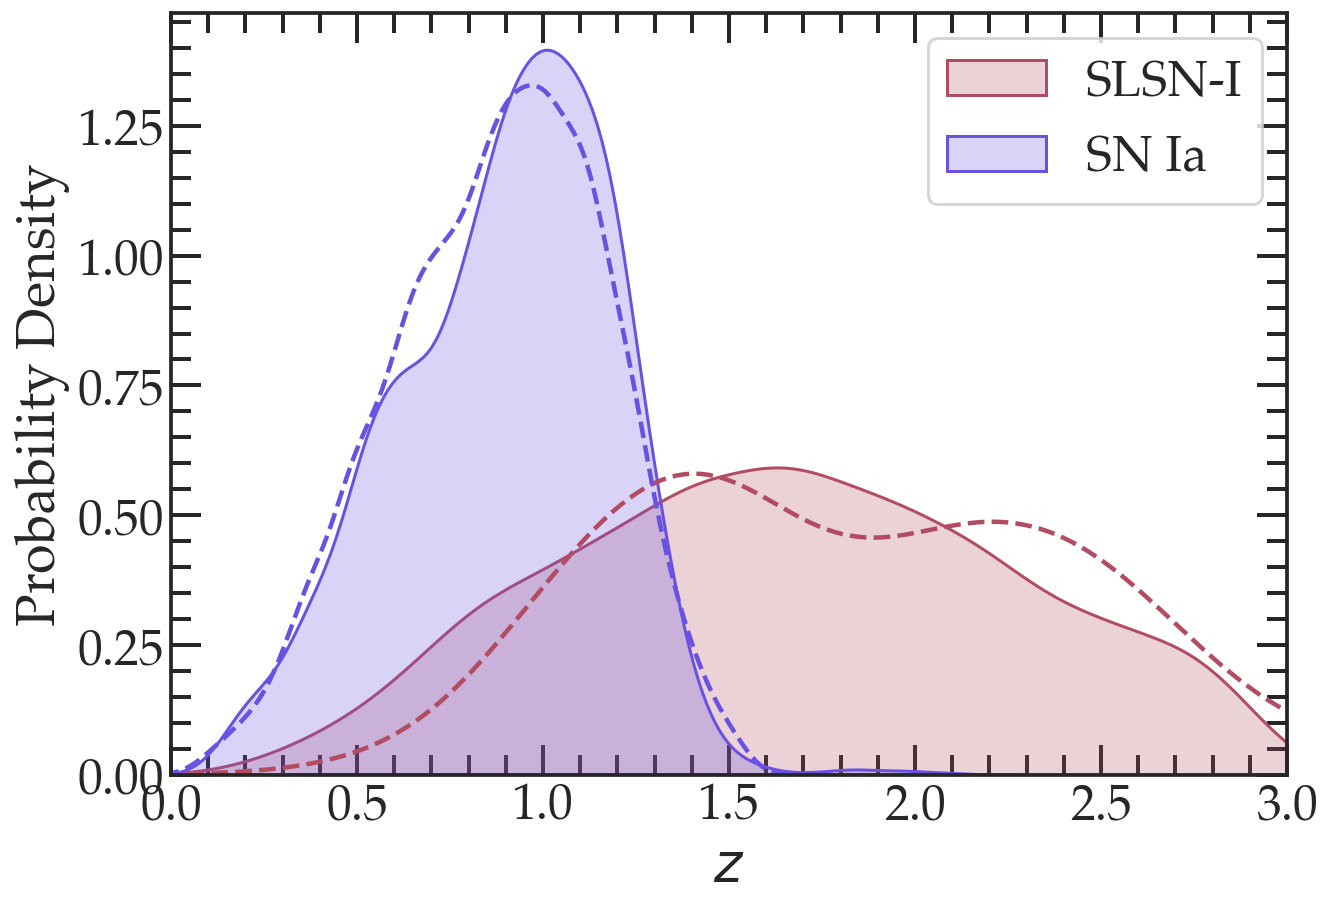

In [107]:
plt.figure(figsize=(10,7))
sns.kdeplot(keepDF_models[0]['z'], label='SLSN-I', shade=True, color='#B24C63') #bins=np.linspace(0, 3, 15), alpha=0.5)
sns.kdeplot(keepDF_models[1]['z'], label='SN Ia', shade=True, color='#6951E1') #bins=np.linspace(0, 3, 15), alpha=0.5)
#sns.kdeplot(keepDF_models[2]['z'], label='SN II', shade=True, color='#6951E1', alpha=0.3) #bins=np.linspace(0, 3, 15), alpha=0.5)
sns.kdeplot(plasticc_SLSNI['true_z'],  color='#B24C63', ls='--')
sns.kdeplot(plasticc_SNIa['true_z'], color='#6951E1', ls='--')
#sns.kdeplot(plasticc_SNII['true_z'], color='#6951E1', ls='--')
plt.legend()
plt.xlabel("$z$");
plt.ylabel("Probability Density");
plt.xlim((0, 3))
plt.savefig("DDF_Plasticc_basicValidation.png",dpi=200, bbox_inches='tight')

In [54]:
galids = []
for df in classes:
    galids.append(df['SIM_HOSTLIB_GALID'].values)
galids = np.concatenate(galids)

In [58]:
galid_df = pd.DataFrame({'GALID':galids})
galid_df.to_csv("/Users/agagliano/Documents/Research/SCOTCH/data/GALIDs_5kSet.tar.gz", index=False)

In [ ]:
sns.set_context("talk")

org = 0

tick_labels = np.array([150, 120, 90, 60, 30, 0, 330, 300, 270, 240, 210])
tick_labels = np.remainder(tick_labels+360+org,360)
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111, projection='mollweide')
ax.set_xticklabels(tick_labels)
ax.title.set_fontsize(15)
ax.set_xlabel("RA")
ax.set_ylabel("Dec")
ax.grid(True)
symb = ['o', '^','d','D','P', '*', '.', '+', 1, 8, 's', '<']

for i in np.arange(5):
    tclass = classes[i]
    RA = tclass['SIM_RA'].values
    Dec = tclass['SIM_DEC'].values
    x = np.remainder(RA+360-org,360) # shift RA values
    ind = x>180
    x[ind] -=360    # scale conversion to [-180, 180]
    x=-x    # reverse the scale: East to the left
    color = tclass['SIM_REDSHIFT_HELIO'].values
    c = ax.scatter(np.radians(x),np.radians(Dec), c=color, zorder=300, cmap='Reds', s=10, lw=1, marker=symb[i], label=names[i], alpha=0.8)  # convert degrees to radians

legend_elements = []
for i in np.arange(5):
    legend_elements.append(Line2D([0], [0], marker=symb[i], color='w', label=names[i],
                        markerfacecolor='w', mec='k',markersize=15, mew=1))
    
leg1 = ax.legend(fontsize=18, handles=legend_elements, loc='lower right', handletextpad=0.0, borderaxespad=1.5,labelspacing=0.5, bbox_to_anchor=(0.73,0.7), ncol=3,frameon=True, fancybox=True, edgecolor='k')
    
x = plt.colorbar(c,fraction=0.046, pad=0.1, label=r'Redshift (z)', orientation="horizontal")

lon_array = np.arange(0,360)
lat = 0.
eq_array = np.zeros((360,2))
for lon in lon_array:
    ga = ephem.Galactic(np.radians(lon), np.radians(lat))
    eq = ephem.Equatorial(ga)
    eq_array[lon] = np.degrees(eq.get())
RA = eq_array[:,0]
Dec = eq_array[:,1]

x = np.remainder(RA+360-org,360) # shift RA values
ind = x>180
x[ind] -=360    # scale conversion to [-180, 180]
x=-x    # reverse the scale: East to the left
Gal_Equator = pd.DataFrame({'x':np.radians(x), 'y':np.radians(Dec)})
Gal_Equator.sort_values(by='x', inplace=True)
ax.plot(Gal_Equator['x'], Gal_Equator['y'], lw=3, c='#88B7B5')
#plt.savefig("../plots/GP_Simulated_allSamples_LSST_Redshifts.png",dpi=300, bbox_inches='tight')

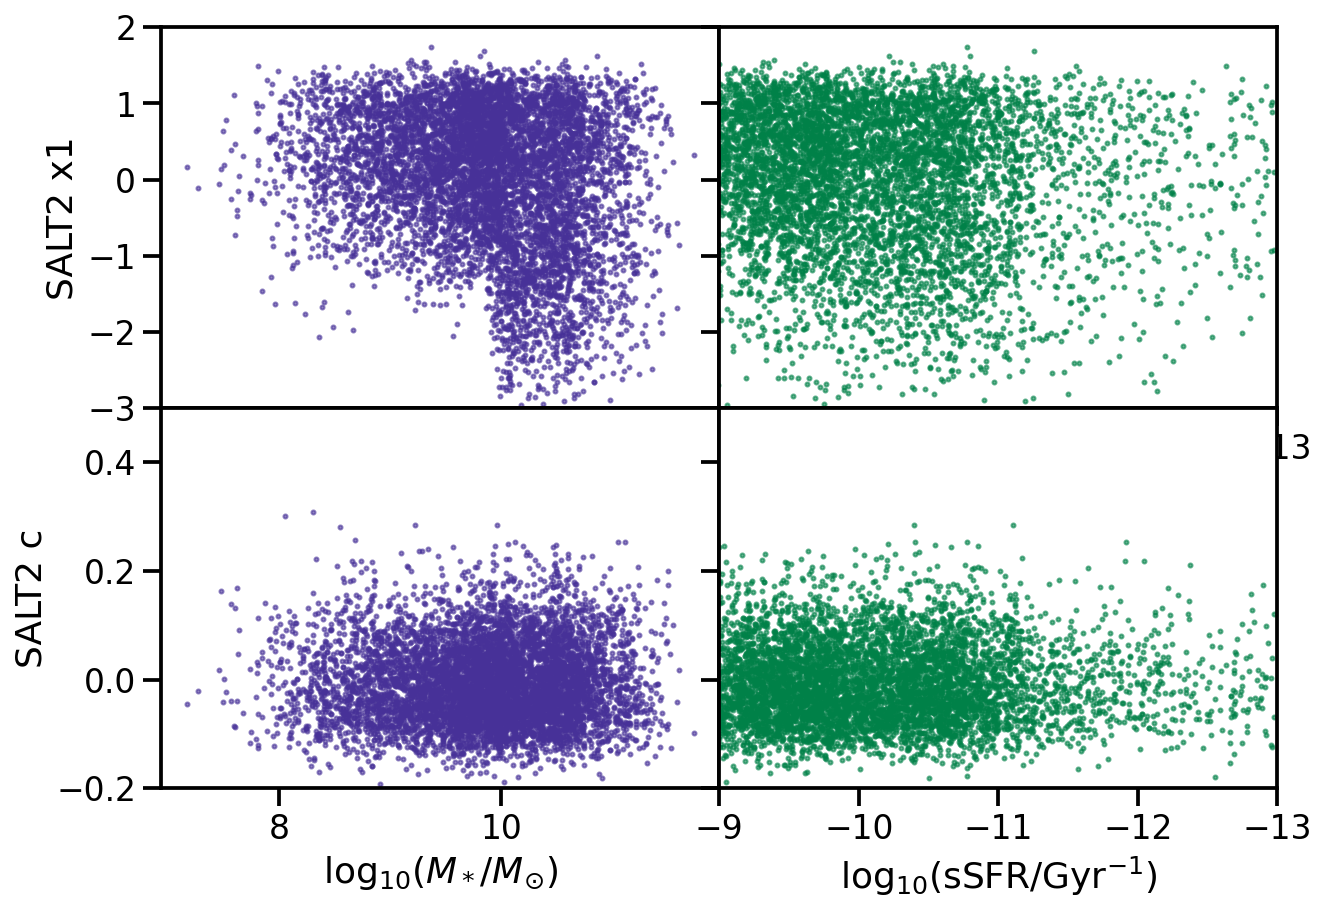

In [161]:
meds = []
stds = []

heatmap, xedges, yedges = np.histogram2d(SNIa['SIM_HOSTLIB(LOGMASS_TRUE)'], SNIa['SIM_SALT2x1'], bins=(512, 512))
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

fig, axs = plt.subplots(2, 2,figsize=(10,7))
axs[0, 0].plot(SNIa['SIM_HOSTLIB(LOGMASS_TRUE)'], SNIa['SIM_SALT2x1'], 'o', alpha=0.6, ms=2, c='#473198')
#axs[0, 0].imshow(heatmap.T, extent=extent)
axs[1, 0].plot(SNIa['SIM_HOSTLIB(LOGMASS_TRUE)'], SNIa['SIM_SALT2c'], 'o', alpha=0.6, ms=2, c='#473198')
axs[0, 1].plot(np.log10(10**(SNIa['SIM_HOSTLIB(LOG_SFR)'])/10**(SNIa['SIM_HOSTLIB(LOGMASS_TRUE)'])), SNIa['SIM_SALT2x1'], 'o', alpha=0.6, ms=2, c='#008148')
axs[1, 1].plot(np.log10(10**(SNIa['SIM_HOSTLIB(LOG_SFR)'])/10**(SNIa['SIM_HOSTLIB(LOGMASS_TRUE)'])), SNIa['SIM_SALT2c'], 'o', alpha=0.6, ms=2, c='#008148')
axs[0, 0].set_ylim((-3, 2))
axs[0, 1].set_ylim((-3, 2))
plt.subplots_adjust(wspace=0, hspace=0)
axs[1, 0].set_ylim((-0.2, 0.5))
axs[1, 1].set_ylim((-0.2, 0.5))
axs[1,1].set_xlim((-9, -13))
axs[0,1].set_xlim((-9, -13))
axs[0,1].yaxis.set_ticklabels([])
axs[1,1].yaxis.set_ticklabels([])
axs[1,1].set_xlabel(r"log$_{10}$(sSFR/Gyr$^{-1}$)")
axs[1,0].set_xlabel(r"log$_{10}$($M_*/M_{\odot}$)")
axs[1,0].set_ylabel(r"SALT2 c")
axs[0,0].set_ylabel(r"SALT2 x1");
plt.savefig("x1c_Grid.png",bbox_inches='tight', dpi=200)

In [173]:
meds = []
stds = []

Nbins = 6
plt.figure(figsize=(10,7))
for i in np.arange(Nbins):
    tempSNIa_cut = SNIa_cut[(SNIa_cut['SIM_HOSTLIB(LOGMASS_TRUE)'] > bins[i]) & (SNIa_cut['SIM_HOSTLIB(LOGMASS_TRUE)'] < bins[i+1])]
    medVal = np.nanmedian(tempSNIa_cut['SIM_SALT2x1'])
    stdVal = np.nanstd(tempSNIa_cut['SIM_SALT2x1'])
    meds.append(medVal)
    stds.append(stdVal)
plt.plot(SNIa_cut['SIM_HOSTLIB(LOGMASS_TRUE)'], SNIa_cut['SIM_SALT2x1'], 'o', alpha=0.2, ms=8, c='#A4243B')
plt.errorbar(bins[:-1], meds, stds, fmt='o-', ms=12, lw=3, zorder=100, c='k')
plt.axhline(y=0,zorder=100, c='#273E47', lw=3)
plt.ylim((-0.3, 0.3))
plt.xlim((7, 12))

NameError: name 'SNIa_cut' is not defined

<Figure size 720x504 with 0 Axes>

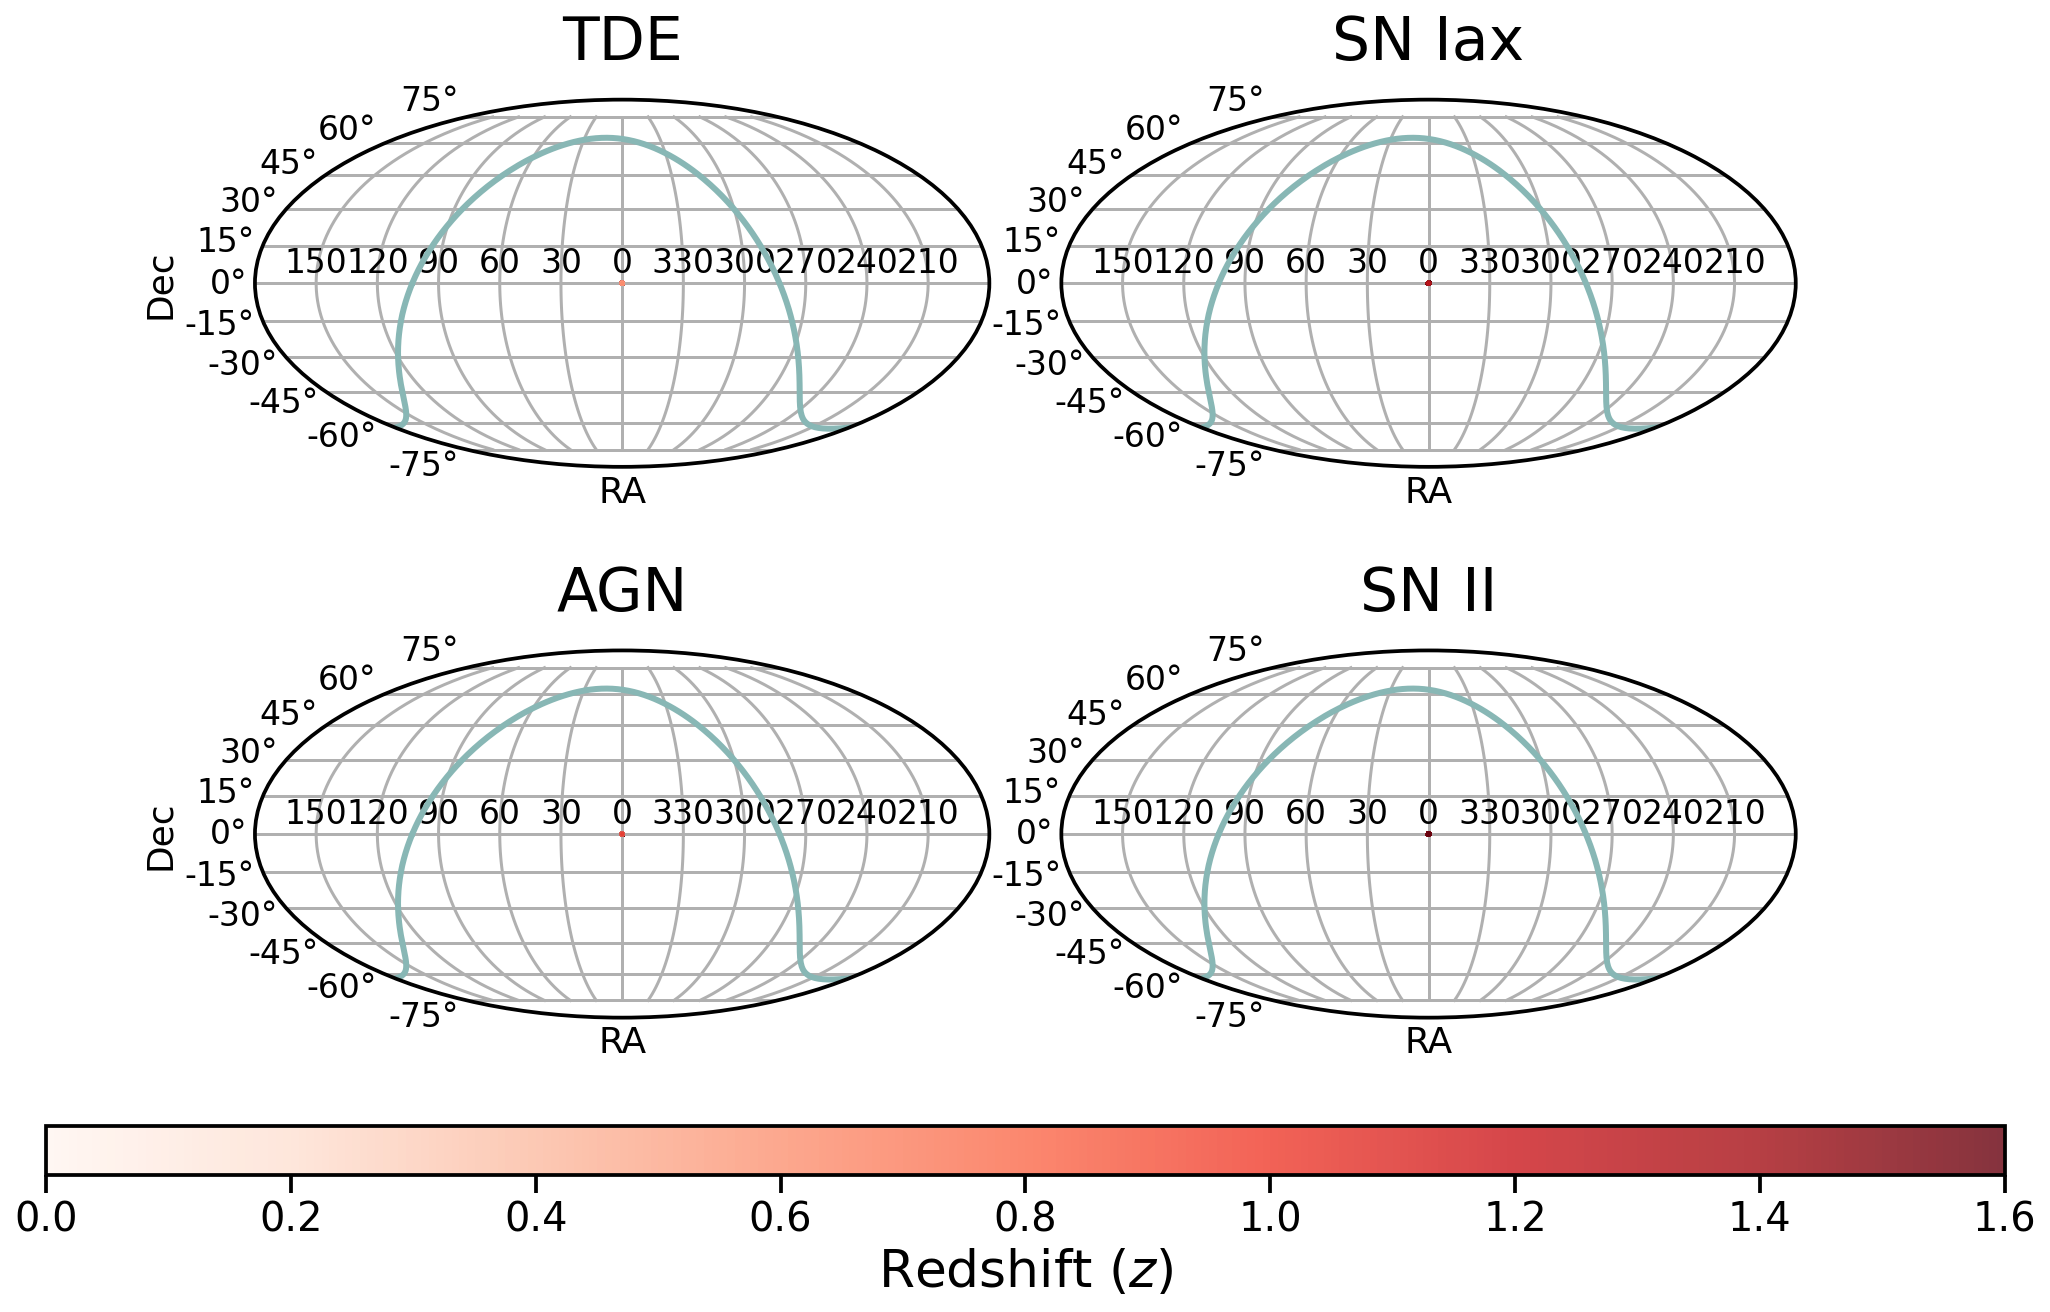

In [174]:
sns.set_context("talk")
cols = sns.color_palette("muted", 12)#['#437C90', '#255957', '#EEEBD3', '#A98743','#F7C548','#9C3848','#590925','#CC2936','#2E1760','#D65780', '#9A94BC', '#A5C882']
org = 0

tick_labels = np.array([150, 120, 90, 60, 30, 0, 330, 300, 270, 240, 210])
tick_labels = np.remainder(tick_labels+360+org,360)
fig = plt.figure(figsize=(80, 30))
temp = []
for j in np.arange(2):
    for k in np.arange(2):
        ax = fig.add_subplot(6,j+1,k+1, projection='mollweide')
        temp.append(ax)
        ax.set_xticklabels(tick_labels)
        ax.title.set_fontsize(15)
        ax.set_xlabel("RA")
        if j==0:
            ax.set_ylabel("Dec")
        ax.grid(True)
        symb = ['o', '^','d','D','P', '*', '.', '+', 1, 8, 's', '<']
        ax.set_position(pos=[0.1+0.07*j, 0.1+0.15*k,0.1,0.1])
        ax.set_title(names[k +2*j],fontsize=30, pad=20)

        tclass = classes[k+2*j]
        RA = tclass['SIM_RA'].values
        Dec = tclass['SIM_DEC'].values
        x = np.remainder(RA+360-org,360) # shift RA values
        ind = x>180
        x[ind] -=360    # scale conversion to [-180, 180]
        x=-x    # reverse the scale: East to the left
        color = tclass['SIM_REDSHIFT_HELIO'].values
        c = ax.scatter(np.radians(x),np.radians(Dec), c=color, zorder=300, cmap='Reds', s=3, lw=1, marker='o', label=names[j], alpha=0.8, vmin=0., vmax=1.6)  # convert degrees to radians

        legend_elements = []
        
        lon_array = np.arange(0,360)
        lat = 0.
        eq_array = np.zeros((360,2))
        for lon in lon_array:
            ga = ephem.Galactic(np.radians(lon), np.radians(lat))
            eq = ephem.Equatorial(ga)
            eq_array[lon] = np.degrees(eq.get())
        RA = eq_array[:,0]
        Dec = eq_array[:,1]

        x = np.remainder(RA+360-org,360) # shift RA values
        ind = x>180
        x[ind] -=360    # scale conversion to [-180, 180]
        x=-x    # reverse the scale: East to the left
        Gal_Equator = pd.DataFrame({'x':np.radians(x), 'y':np.radians(Dec)})
        Gal_Equator.sort_values(by='x', inplace=True)
        ax.plot(Gal_Equator['x'], Gal_Equator['y'], lw=3, c='#88B7B5')
x = fig.colorbar(c,fraction=0.05, pad=0.1,label=r'Redshift (z)', ax=temp, orientation="horizontal", aspect=40)
x.set_label(label=r'Redshift ($z$)', size='x-large')
x.ax.tick_params(labelsize=20) 
#plt.savefig("../plots/GP_Simulated_allSamples_LSST_Redshifts_MultiClass.png",dpi=300, bbox_inches='tight')

# Now you can use the data doing

IndexError: index 10 is out of bounds for axis 0 with size 10

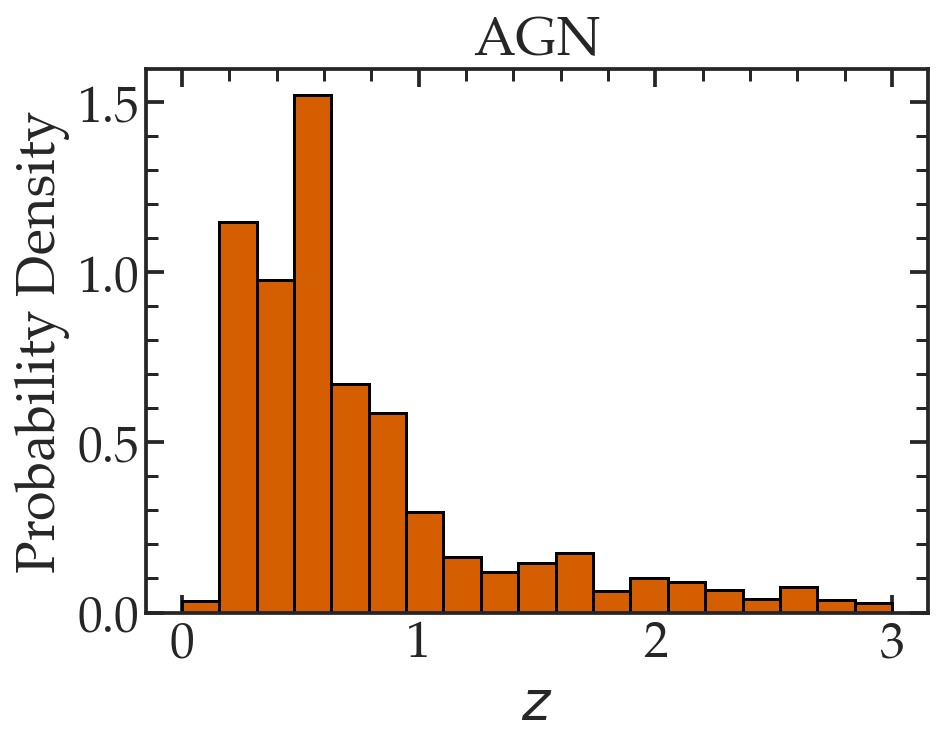

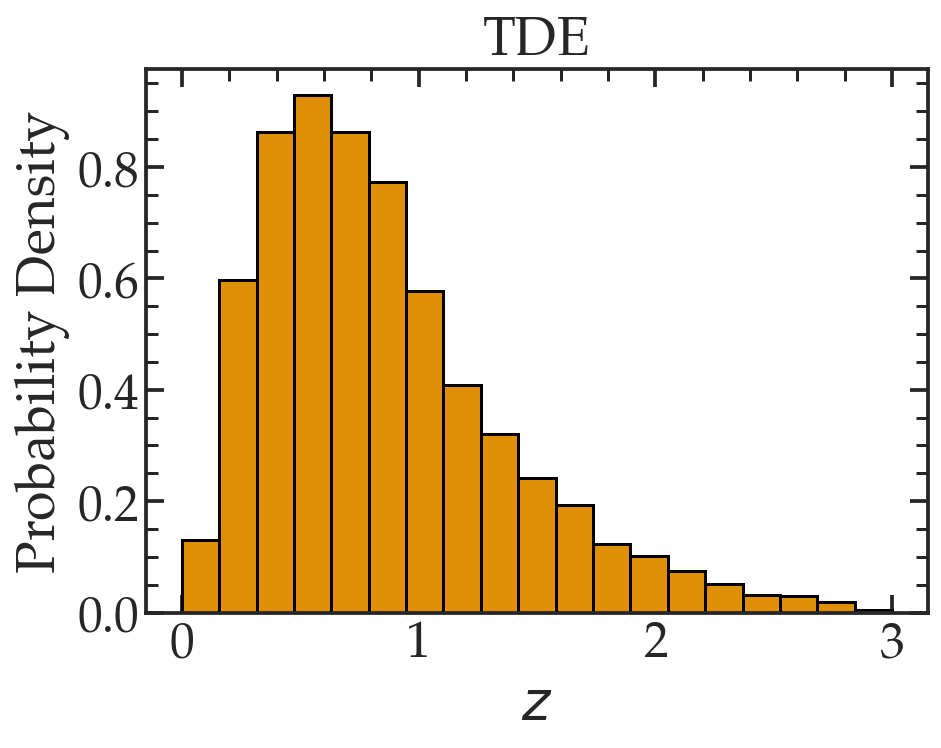

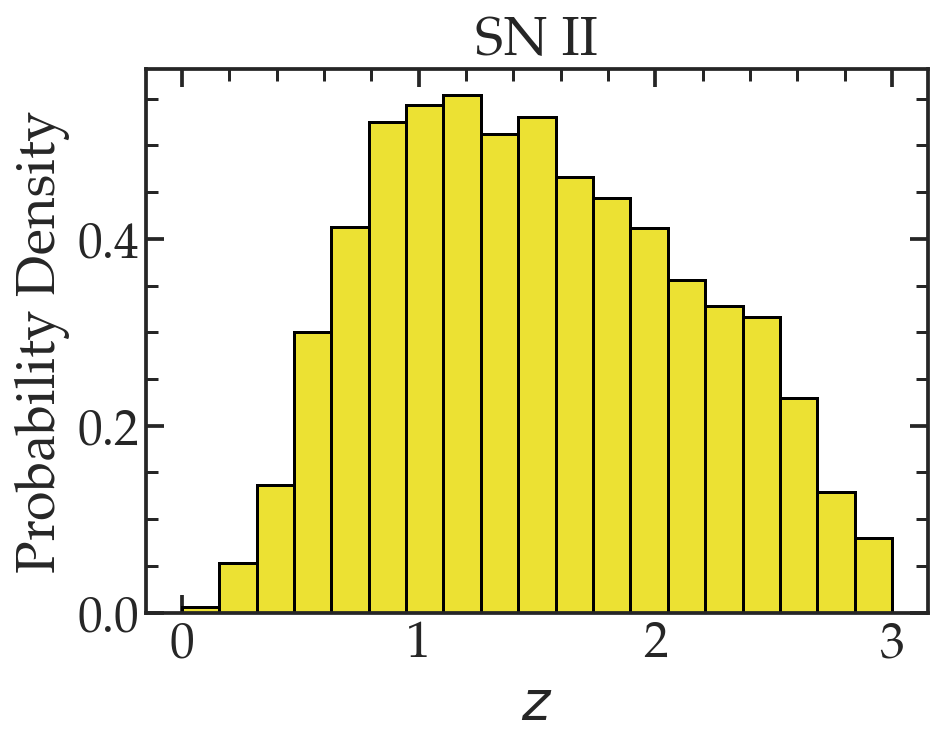

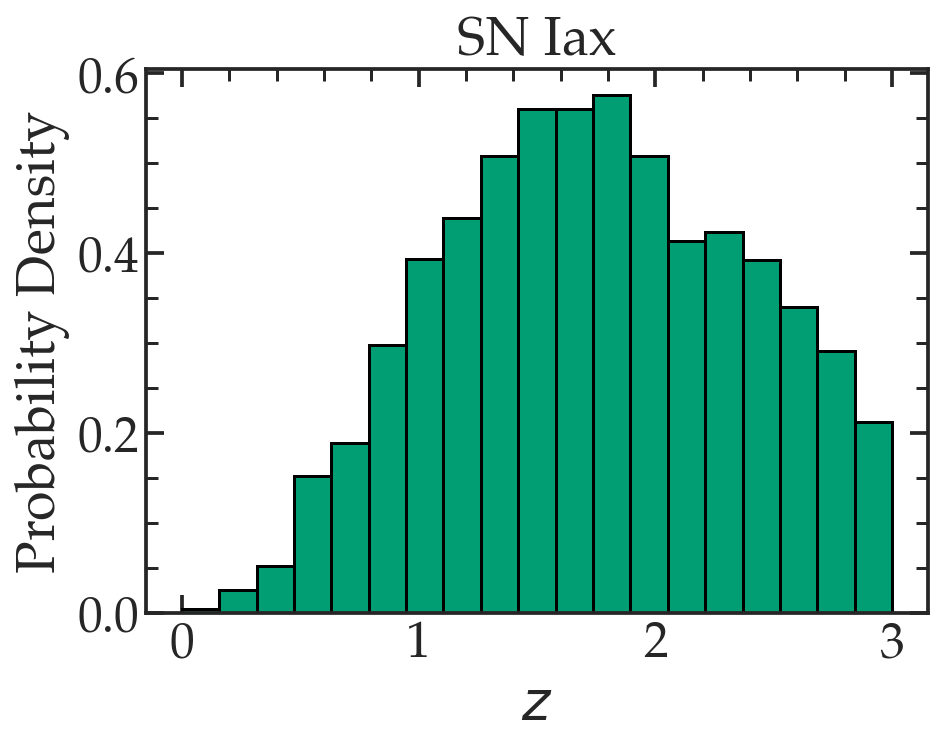

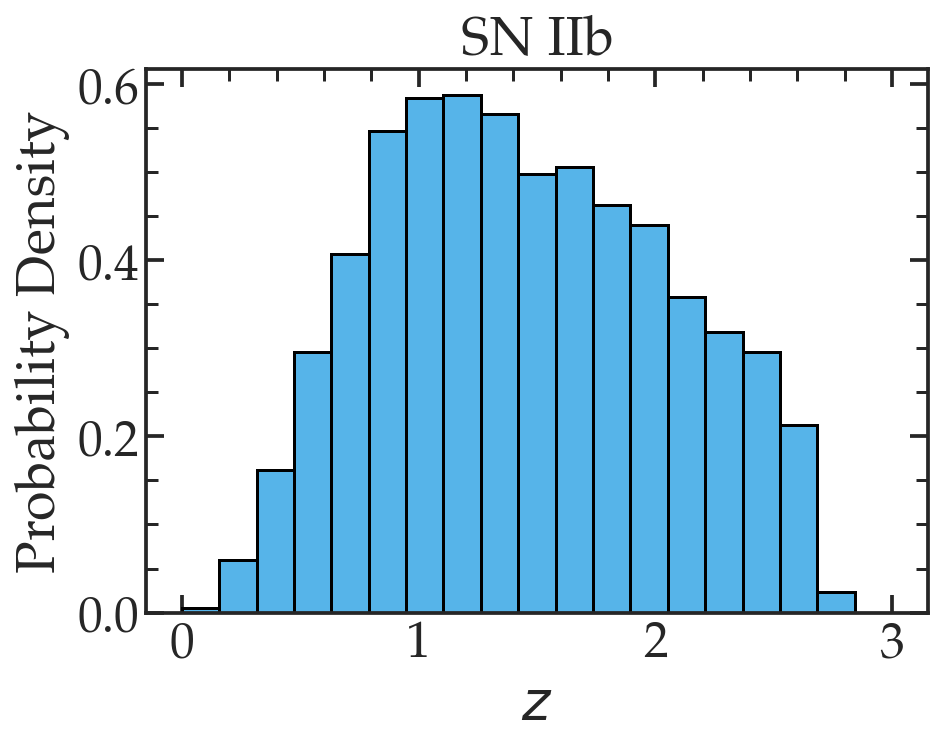

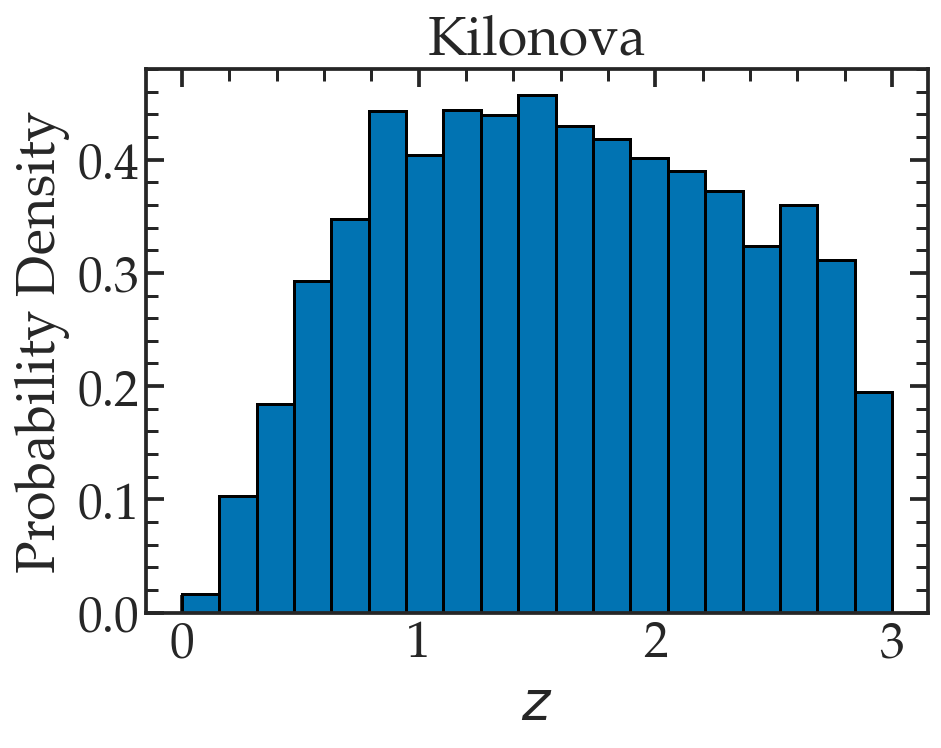

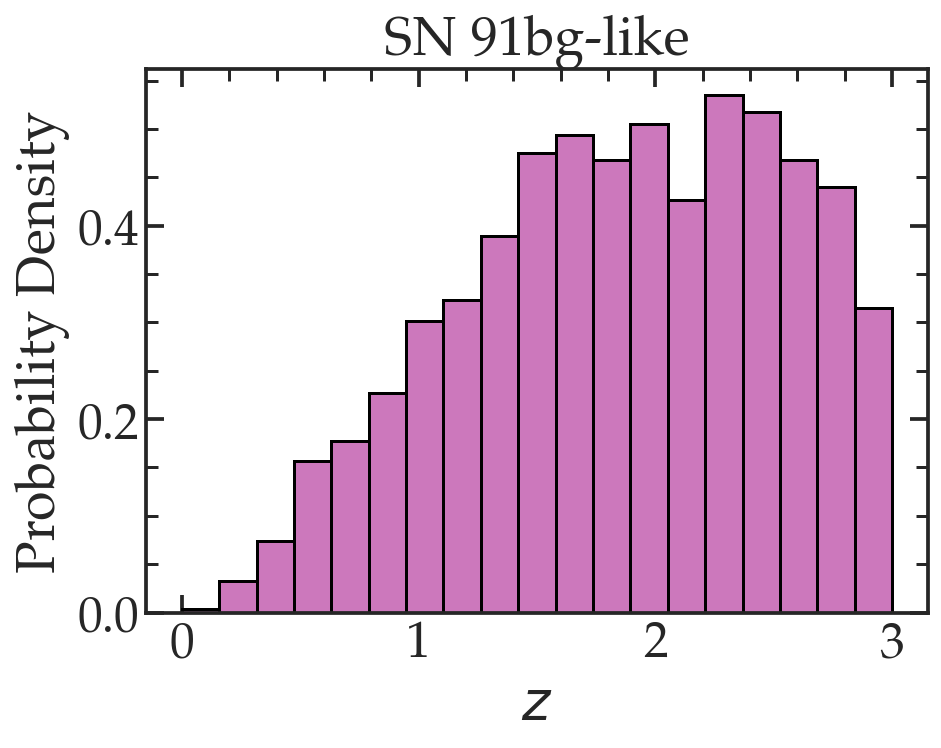

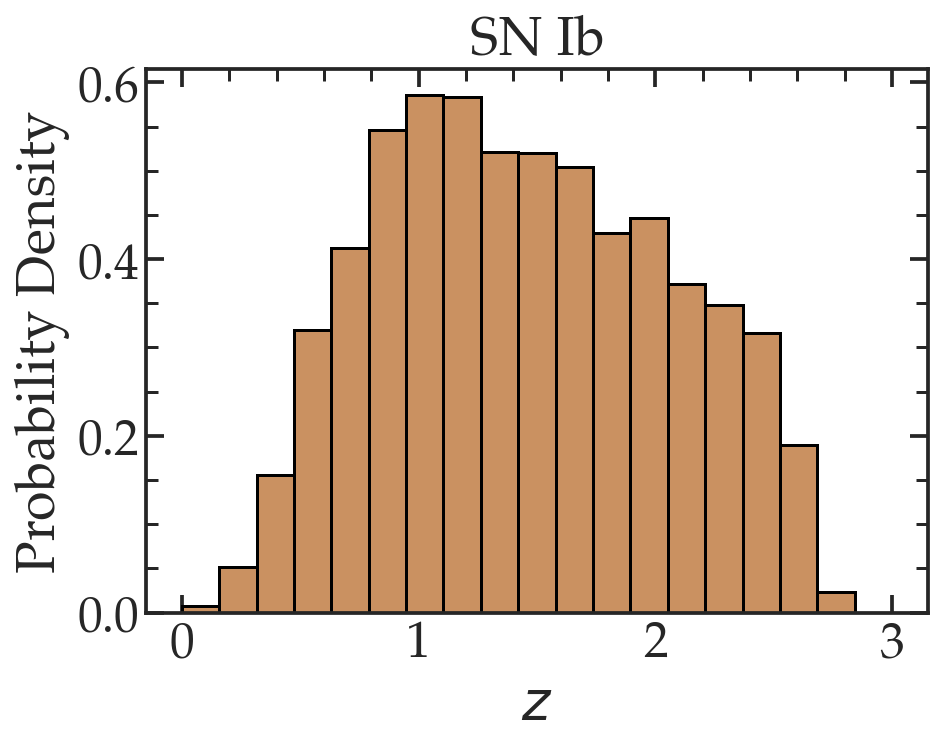

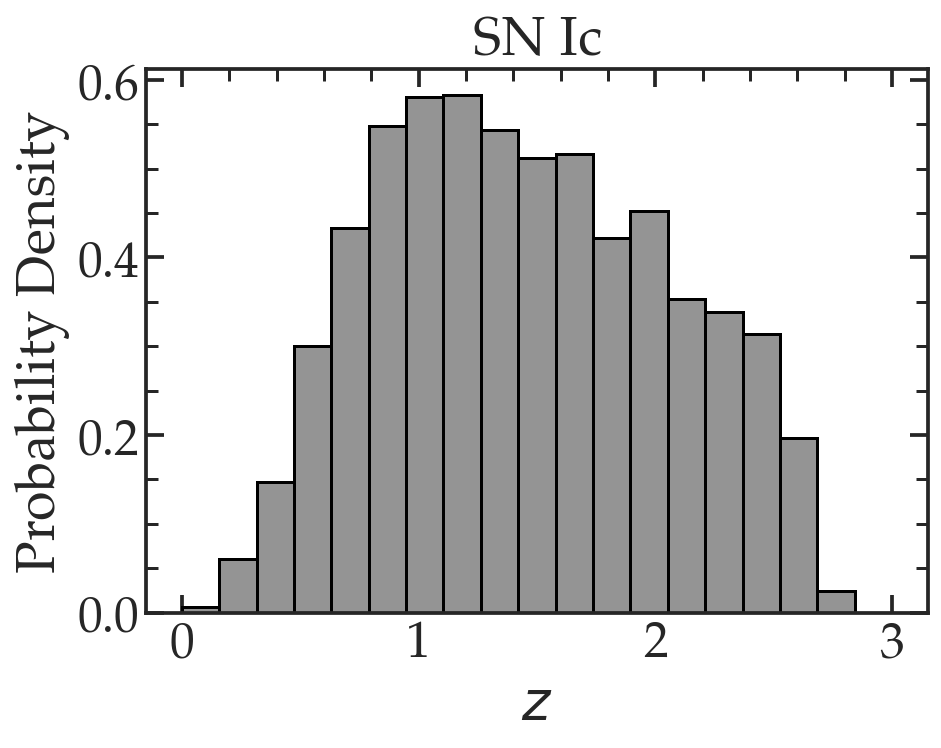

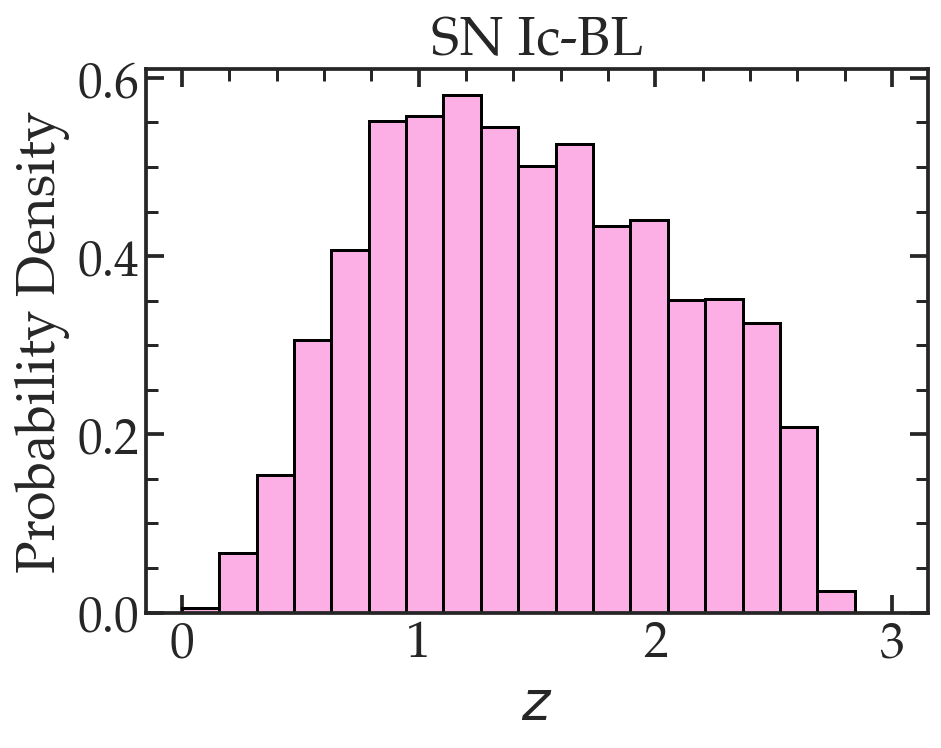

<Figure size 504x360 with 0 Axes>

In [28]:
sns.set_context("talk",font_scale=1.5)

cols = sns.color_palette("colorblind", 10)
cols_hex = cols.as_hex()
cols = np.array([cols[3], cols[1], cols[8], cols[2], cols[9], cols[0], cols[4], cols[5], cols[7],cols[6]])

for i in np.arange(len(classes)):
    plt.figure(figsize=(7,5))
    plt.hist(classes[i]['z'], density=True, color=cols[i], edgecolor='k', bins=np.linspace(0, 3, 20))
    plt.title(names[i])
    plt.xlabel(r"$z$")
    plt.ylabel(r"Probability Density")
    plt.savefig("../plots/GP_SCOTCH_SmallSet_Redshift_%s.png"%(names[i]),bbox_inches='tight',dpi=200)

The `X` contain the data itself. You can take a look at what IDs are present in X by using

In [ ]:
plt.figure(figsize=(10,7))
plt.errorbar(TDE.loc[TDE.index[0], 'mjd_g'], TDE.loc[TDE.index[0], 'mag_g'], yerr=TDE.loc[TDE.index[0], 'magerr_g'], fmt='o-', c='tab:green')
plt.gca().invert_yaxis()
plt.xlabel("MJD")
plt.title("One TDE Lightcurve")
plt.ylabel(r"$g$")

In [30]:
#check out the apparent magnitudes of KN host galaxies: 
GHOST = pd.read_csv("/Users/alexgagliano/Documents/Research/DESC/tables/GHOST_orig/GHOST_restFrame_condenseLabels_cleanColor.tar.gz")
sGRBs = pd.read_csv("/Users/alexgagliano/Documents/Research/sGRBs/SGRBmatchesTable_1028_wAbs.csv")
bands = 'griz'
cols = ['tab:green', 'tab:orange', 'tab:red', 'tab:brown']
for i in np.arange(len(bands)):
    plt.figure(figsize=(10,7))
    plt.hist(GHOST['%sKronMag'%bands[i]], bins=np.linspace(10, 23, 50), color=cols[i], histtype='stepfilled', alpha=0.5, label=r"GHOST $%s$"%bands[i], lw=3, density=True) 
    plt.hist(sGRBs['%sKronMag'%bands[i]], bins=np.linspace(10, 23, 50), color='k', histtype='stepfilled', alpha=0.5, label=r"sGRB $%s$"%bands[i], lw=3, density=True) 
    plt.hist(KN['HOSTGAL_MAG_%s'%bands[i]], bins=np.linspace(10, 23, 50), color=cols[i], histtype='step', alpha=0.5, label=r"SNANA $%s$" %bands[i], lw=3, density=True) 
    plt.legend(loc='upper left')
    plt.savefig("../plots/KN_apparentMag_%s.png"%bands[i], dpi=200, bbox_inches='tight')

FileNotFoundError: [Errno 2] No such file or directory: '/Users/alexgagliano/Documents/Research/DESC/tables/GHOST_orig/GHOST_restFrame_condenseLabels_cleanColor.tar.gz'

classes_plot = classes.copy()
names_plot = names.copy()
%matplotlib inline

sns.set_context("talk",font_scale=1.5)

sns.set_style('white', {'axes.linewidth': 0.5})
plt.rcParams['xtick.major.size'] = 15
plt.rcParams['ytick.major.size'] = 15

plt.rcParams['xtick.minor.size'] = 10
plt.rcParams['ytick.minor.size'] = 10
plt.rcParams['xtick.minor.width'] = 2
plt.rcParams['ytick.minor.width'] = 2

plt.rcParams['xtick.major.width'] = 2
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True
plt.rcParams['xtick.top'] = False #just for these plots
plt.rcParams['ytick.right'] = False #just for these plots

plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
## for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

for i in np.arange(len(classes_plot)):
    #try:
    logmass = classes_plot[i]["SIM_HOSTLIB(LOGMASS_TRUE)"].values
    logsfr = classes_plot[i]["SIM_HOSTLIB(LOG_SFR)"].values
   # except:
   #     print("need to add in the mass and sfr info for index %i"%i)
   #     logmass = classes[i]["HOSTGAL_LOGMASS"].values
   #     logsfr = np.log10(classes[i]["HOSTGAL_sSFR"].values*10**classes[i]["HOSTGAL_LOGMASS"].values)   
   #     continue
    g = sns.JointGrid(x=logmass, y=logsfr,  xlim=(7, 11), ylim=(-6, 2), height=7)
    g = g.plot_joint(sns.scatterplot, hue=classes_plot[i]["SIM_REDSHIFT_HELIO"].values, palette='coolwarm', edgecolor="k", s=15, alpha=0.8,linewidth=0.1, hue_norm=(0, 3), legend=False)
    g.ax_joint.text(7.5, 1.2, "%s"%names_plot[i])
    
    g.ax_joint.set_ylabel("log[SFR($M_{\odot}\;\mathrm{yr}^{-1}$) ]")
    g.ax_joint.set_xlabel(r"log[Stellar Mass ($M_{\odot}$) ]")
    
    _ = g.ax_marg_x.hist(logmass,
                          bins=np.linspace(7., 11., 50), density=True, histtype ='step', color='k')
    _ = g.ax_marg_y.hist(logsfr, 
                          orientation="horizontal",
                          bins=np.linspace(-6., 2., 50), density=True,histtype ='step', color='k')
    
    if names[i] == 'Kilonova':
        g.ax_joint.errorbar(10.777, np.log10(0.08), fmt='d', uplims=[1], yerr=0.3, xerr=0.3,  c='#06A77D', ms=15, mec='k')
    plt.savefig("../plots/GP_ELAsTiCCValidation_SmallSet_BubblePlot_%s.png"%names_plot[i].replace(" ", ""),bbox_inches='tight',dpi=200)

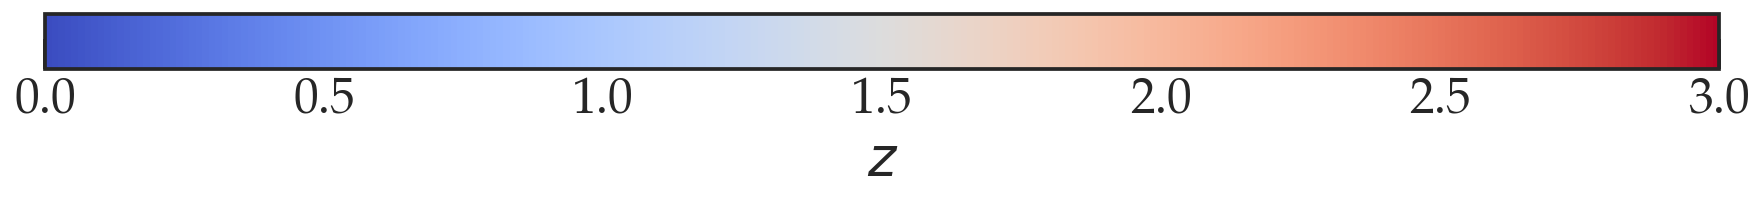

In [144]:
fig, ax = plt.subplots(figsize=(15, 1))
fig.subplots_adjust(bottom=0.5)

cmap = mpl.cm.coolwarm
norm = mpl.colors.Normalize(vmin=0, vmax=3)

cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm,
                                orientation='horizontal', ticks=np.linspace(0, 3, 7))
cb1.set_label(r'$z$')
fig.savefig("../plots/Colorbar_BubblePlots.png",dpi=200,bbox_inches='tight')

In [75]:
GHOST = pd.read_csv("/Users/agagliano/Documents/Research/GHOST/Data/database/GHOST_flagCuts_restFrame.csv")

In [ ]:
from astropy.cosmology import WMAP7
z = np.linspace(0.01, 1.5, 60)
absCut= []
for onez in z:
    absCut.append(28 - WMAP7.distmod(onez).value)

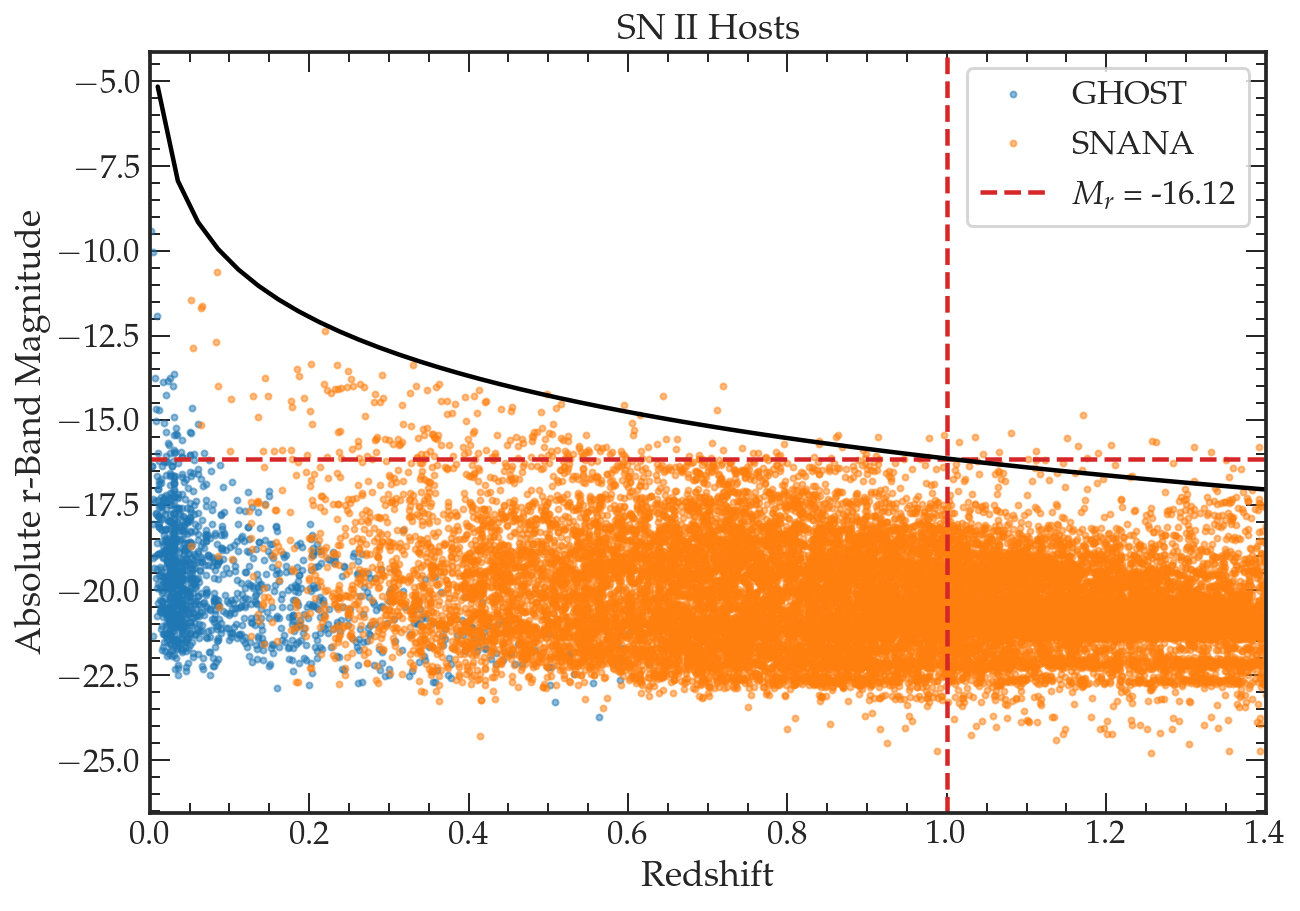

In [203]:
val = 28 - WMAP7.distmod(1).value

plt.figure(figsize=(10,7))
plt.plot(GHOST.loc[GHOST['TransientClass'] == 'SN II', 'TransientRedshift'],GHOST.loc[GHOST['TransientClass'] == 'SN II', 'rKronMag_SDSS_abs'], 'o',ms=3, label='GHOST', alpha=0.5)
plt.plot(classes[2]['SIM_REDSHIFT_HELIO'], classes[2]['Mag_true_r_sdss_z0'], 'o', ms=3, label='SNANA', alpha=0.5)
plt.axvline(x=1.0,  ls='--', c='tab:red')
plt.axhline(y=val, ls='--', c='tab:red', label=r'$M_r$ = %.2f'%val)
plt.plot(z, absCut, c='k')
plt.xlabel("Redshift")
plt.xlim((0, 1.4))
plt.ylabel("Absolute r-Band Magnitude")
plt.legend()
plt.title("SN II Hosts")
plt.savefig("/Users/alexgagliano/Documents/Research/DESC/transient-host-sims/plots/SNII_truncatedSample.png",dpi=200, bbox_inches='tight')

/var/folders/5v/w17zxffn07nf1f90q2rfbdym0001vx/T/ipykernel_47843/3560841942.py:63: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels([''])


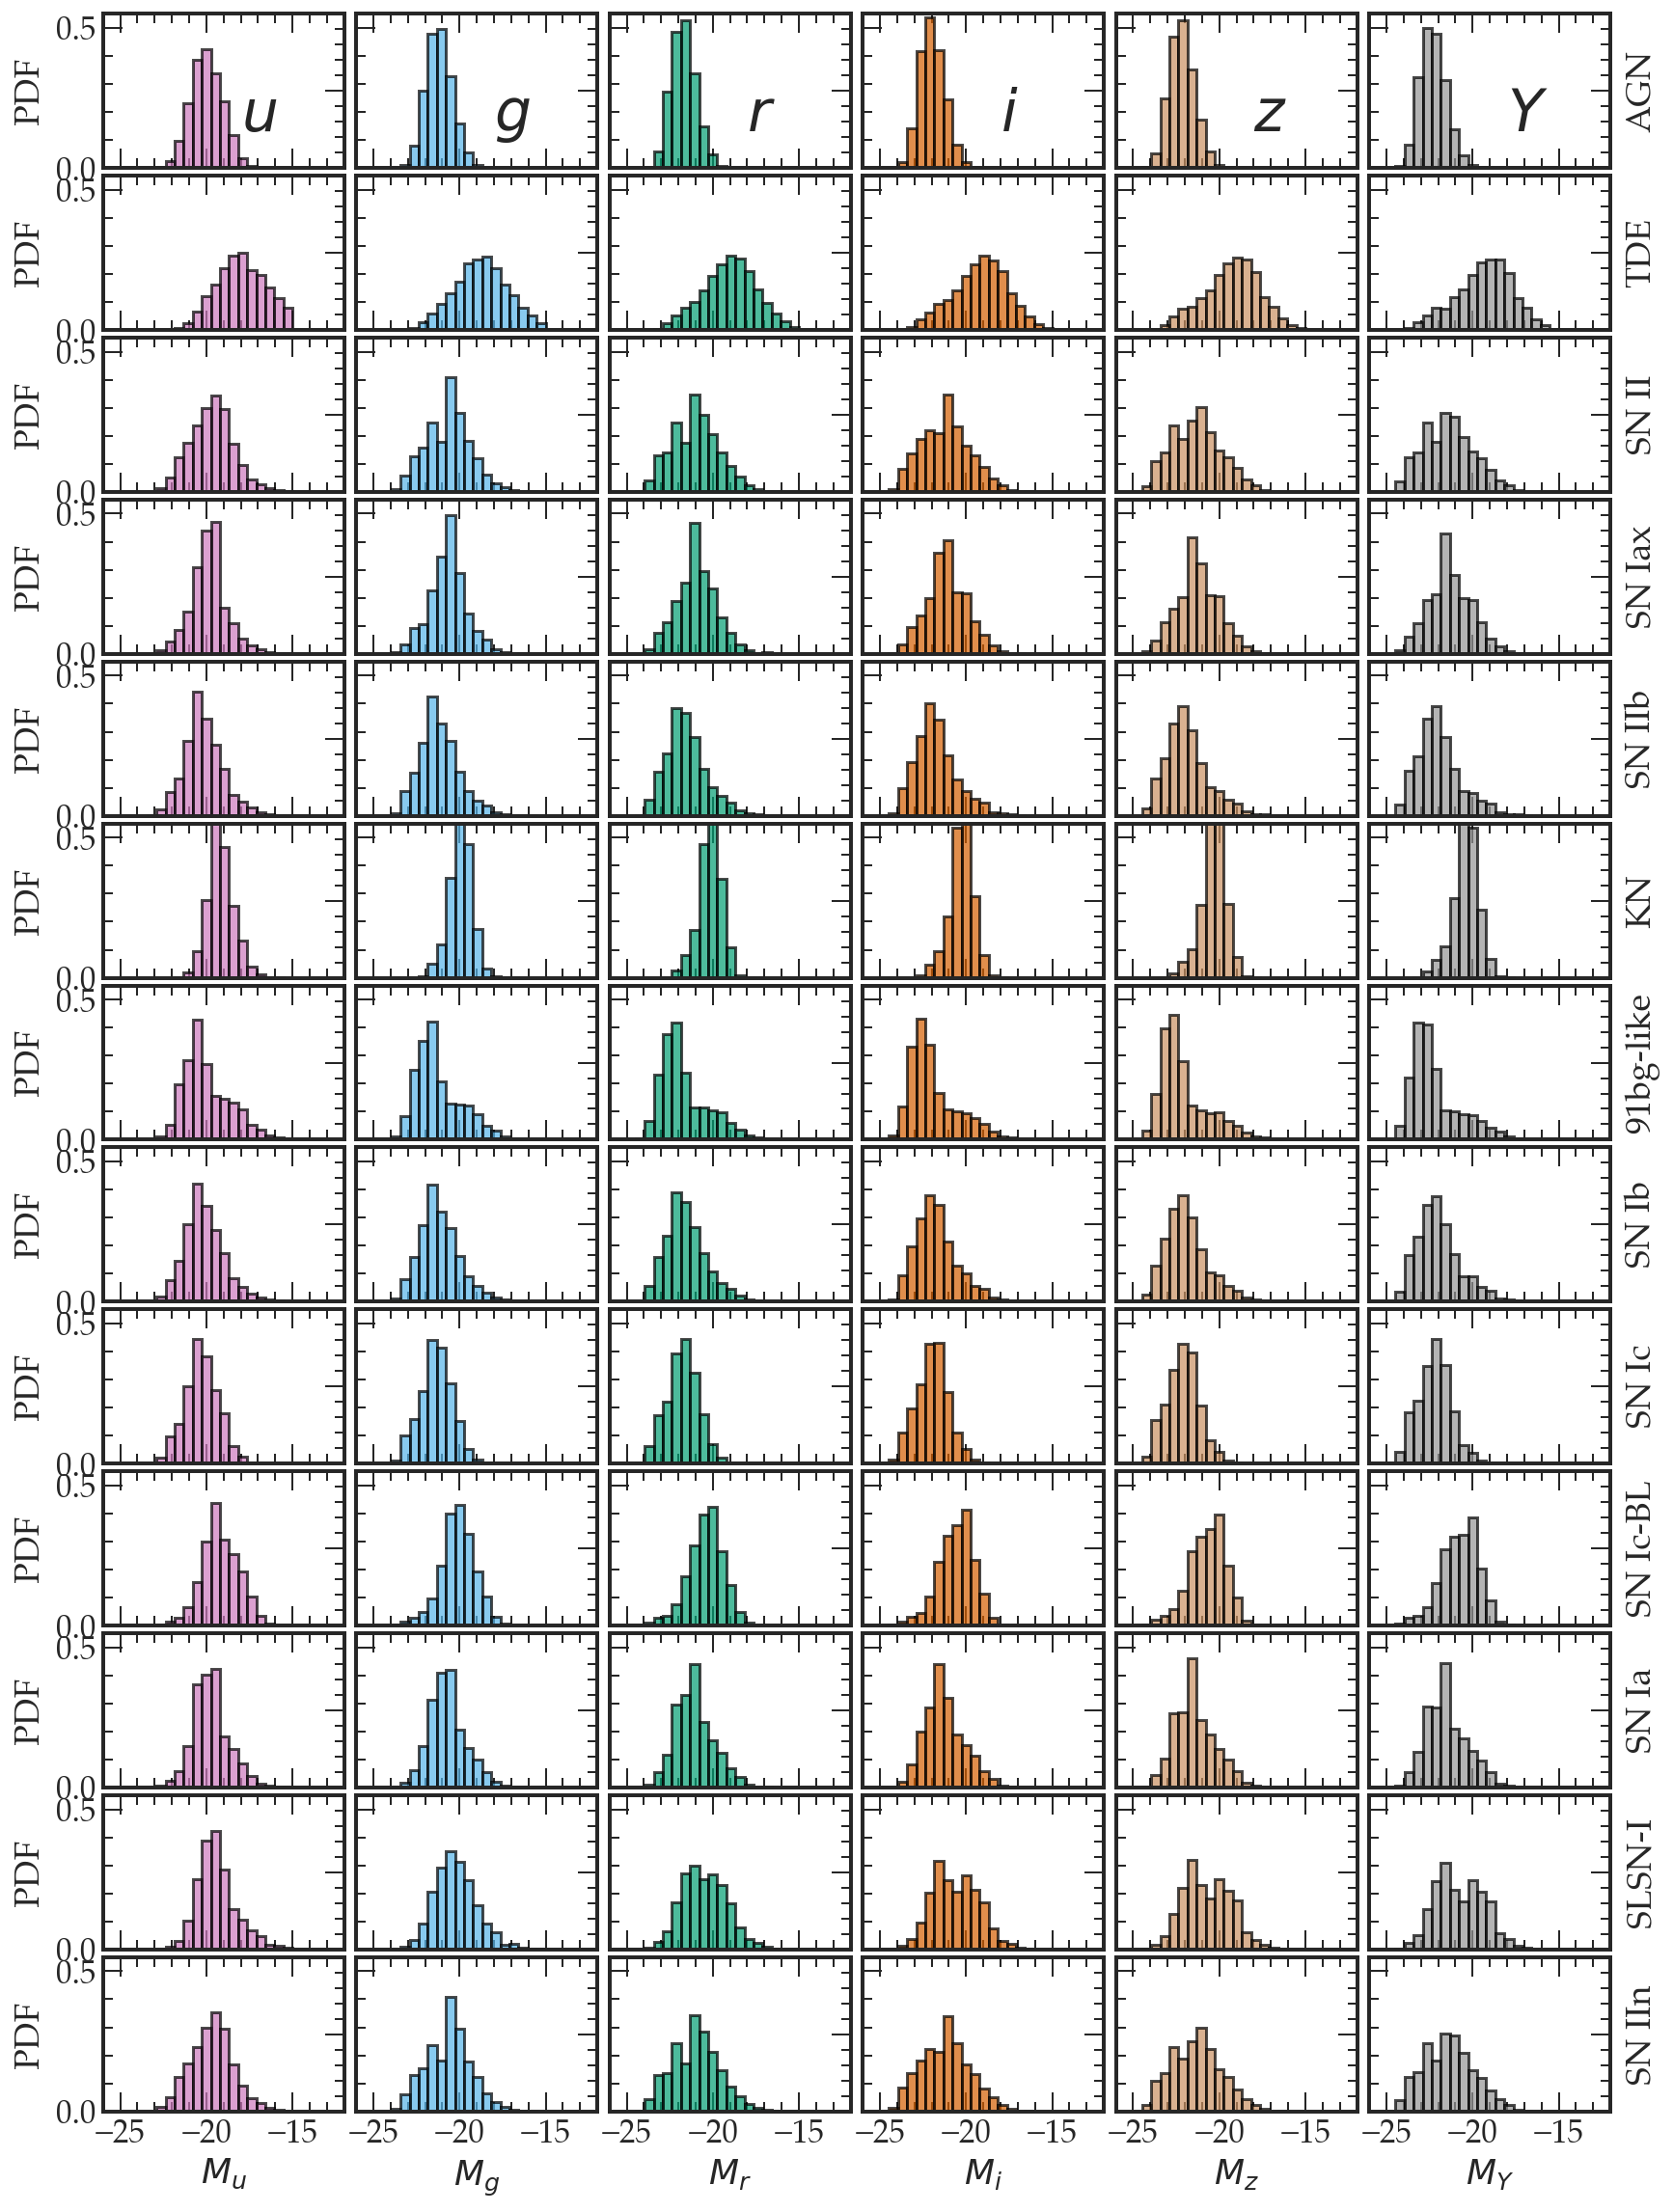

In [135]:
sns.set_context("talk",font_scale=1.)

sns.set_style('white', {'axes.linewidth': 0.5})
plt.rcParams['xtick.major.size'] = 10
plt.rcParams['ytick.major.size'] = 10

plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['ytick.minor.size'] = 5
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.minor.width'] = 1

plt.rcParams['xtick.major.width'] = 1
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['xtick.bottom'] = True
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.left'] = True
plt.rcParams['ytick.right'] = True

plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
## for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

bands = ['u', 'g', 'r', 'i', 'z', 'Y']

cols = sns.color_palette("colorblind", 11)
cols_hex = cols.as_hex()
cols = np.array([cols[3], cols[1], cols[8], cols[2], cols[9], cols[0], cols[4], cols[5], cols[7],cols[6]])
cols = np.array([sns.color_palette("colorblind", 10)[4], cols[4], cols[3], cols[0], cols[7], cols[8]]) #u and y probably need changing

fig, axs = plt.subplots(figsize=(14,20), nrows=13, ncols=6,sharex=True, sharey=True, gridspec_kw={'wspace':0.05, 'hspace':0.05})
for i in np.arange(len(classes)):
    for j in np.arange(len(bands)):
        
        classes_plot = classes[i]
        #classes_plot = classes[i].copy()
        
        min_band = -25
        max_band = -15
        
        useNam = names[i]
        if useNam == 'Kilonova':
            useNam = 'KN'
        elif useNam == 'SN 91bg-like':
            useNam = '91bg-like'
        
        axs[i,j].set_xlim((-26, -12))
        axs[i,j].hist(classes_plot['Mag_true_%s_lsst_z0'%bands[j]], color=cols[j], edgecolor='k', bins=np.linspace(min_band, max_band, num=20), density=True, alpha=0.7)
        if i==0:
            axs[i,j].text(-18, 0.13, r"$%s$"%bands[j], fontsize=30)
        ax2 = axs[i,j].twinx()
        ax2.set_yticklabels([''])
        if j==5:
            ax2.set_ylabel(useNam, rotation=90)
        if i==12:
            axs[i,j].set_xlabel(r"$M_{%s}$"%bands[j])
        axs[i,j].set_ylim((0, 0.55))
        if j==0:
            axs[i,j].set_ylabel(r"PDF")
plt.savefig("../plots/MagnitudeGrid_GP_ELAsTiCCValidation_SmallSet.png",bbox_inches='tight',dpi=200)

In [105]:
if False:
    plt.rcParams['xtick.top'] = False #just for these plots
    plt.rcParams['ytick.right'] = False #just for these plots

    bands = ['g', 'r', 'i', 'z']

    cols = sns.color_palette("colorblind", 10)
    N4993_g = 15.0769
    N4993_r = 14.153
    N4993_i = 13.9573
    N4993_z = 13.42
    N4993_y = 13.2019

    for i in np.arange(len(classes)):
        g_min_r = classes[i]["HOSTGAL_MAG_g"].values - classes[i]["HOSTGAL_MAG_r"].values
        r_min_i = classes[i]["HOSTGAL_MAG_r"].values - classes[i]["HOSTGAL_MAG_i"].values
        redshift = classes[i]['SIM_REDSHIFT_HELIO']

        g_min_r_lowz = g_min_r[redshift < 0.6]
        g_min_r_highz = g_min_r[redshift > 0.6]

        r_min_i_lowz = r_min_i[redshift < 0.6]
        r_min_i_highz = r_min_i[redshift > 0.6]

        names_zset = np.concatenate([[r'$z<0.6$']*len(g_min_r_lowz), [r'$0.6<z<1$']*len(g_min_r_highz)])

        g_min_r_zset = np.concatenate([g_min_r_lowz, g_min_r_highz])
        r_min_i_zset = np.concatenate([r_min_i_lowz, r_min_i_highz])

        zDF = pd.DataFrame({'g-r':g_min_r_zset, 'r-i':r_min_i_zset, 'Range':names_zset})
        g = sns.jointplot(x=zDF['r-i'], y=zDF['g-r'], hue=zDF['Range'], xlim=(0, 1.7), alpha=0.5, ylim=(0, 2.5),height=8)
        g.fig.suptitle(names[i], fontsize=30, y=1.05)
        g.fig.set_figwidth(12)
        g.fig.set_figheight(8)
        plt.xlabel(r"$r-i$")
        plt.ylabel(r"$g-r$")
       # plt.savefig("../plots/GP_ELAsTiCCValidation_SmallSet_%s_HockeyPlot.png"%names[i],bbox_inches='tight',dpi=200)

In [68]:
N4993_g = 15.0769
N4993_r = 14.153
N4993_i = 13.9573
N4993_z = 13.42
N4993_y = 13.2019

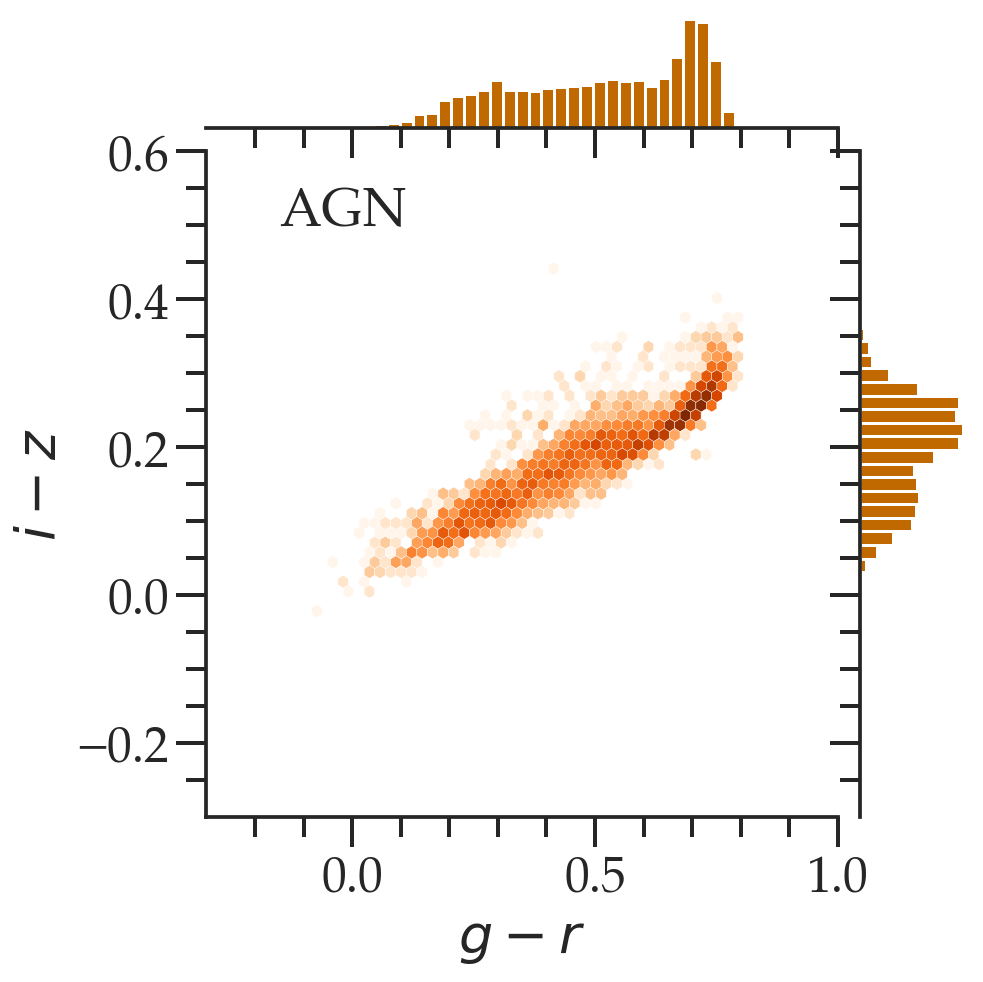

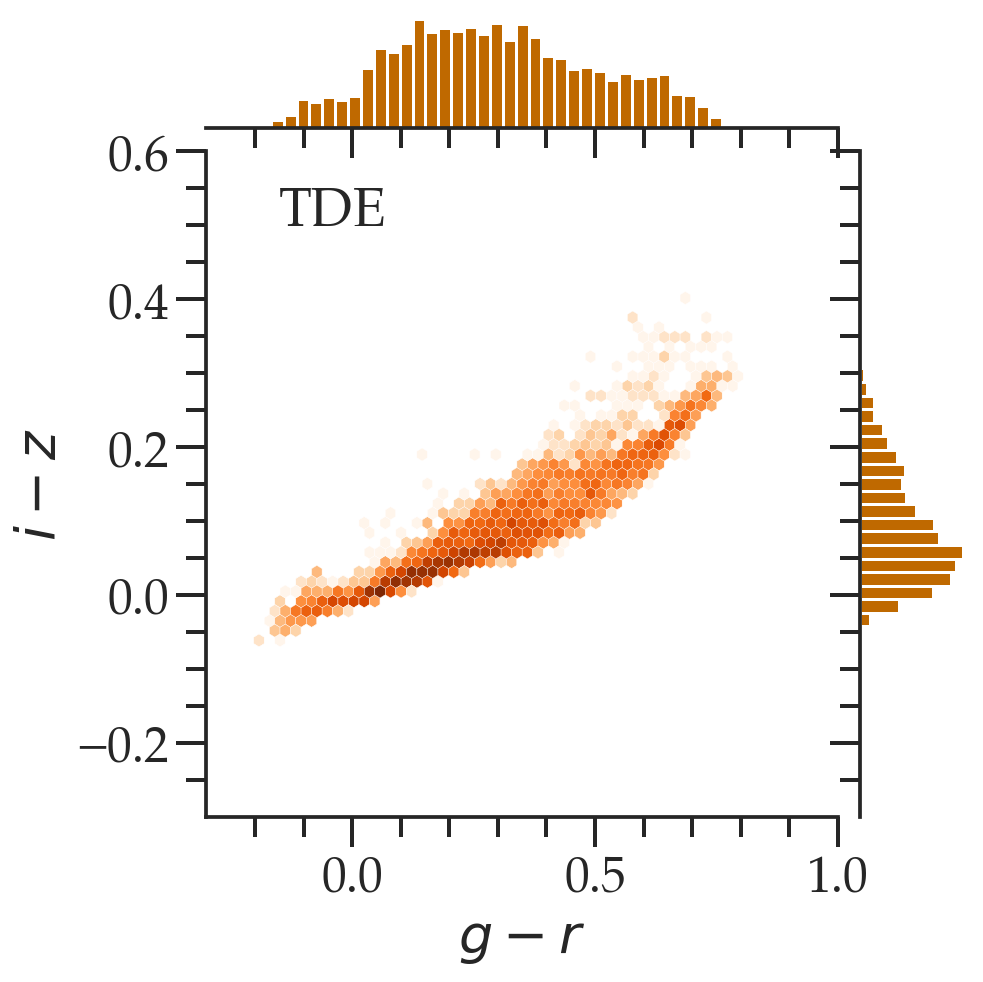

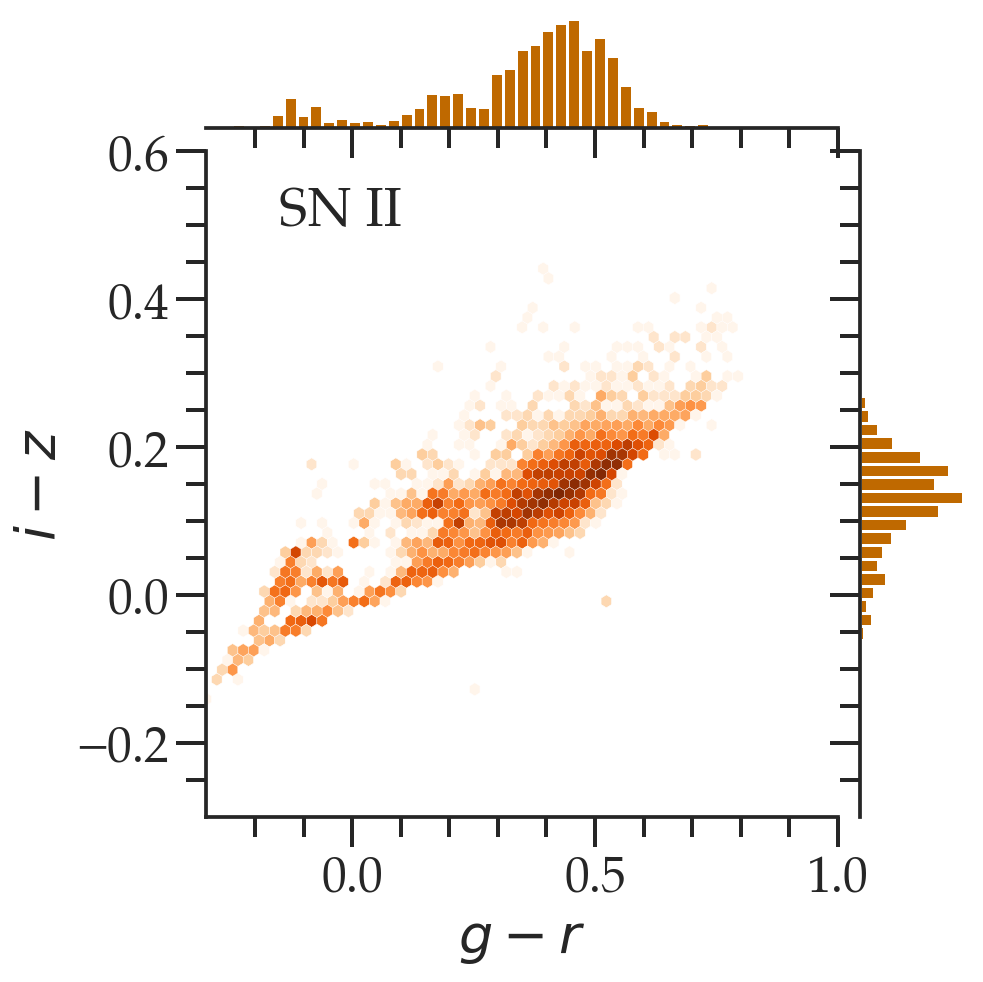

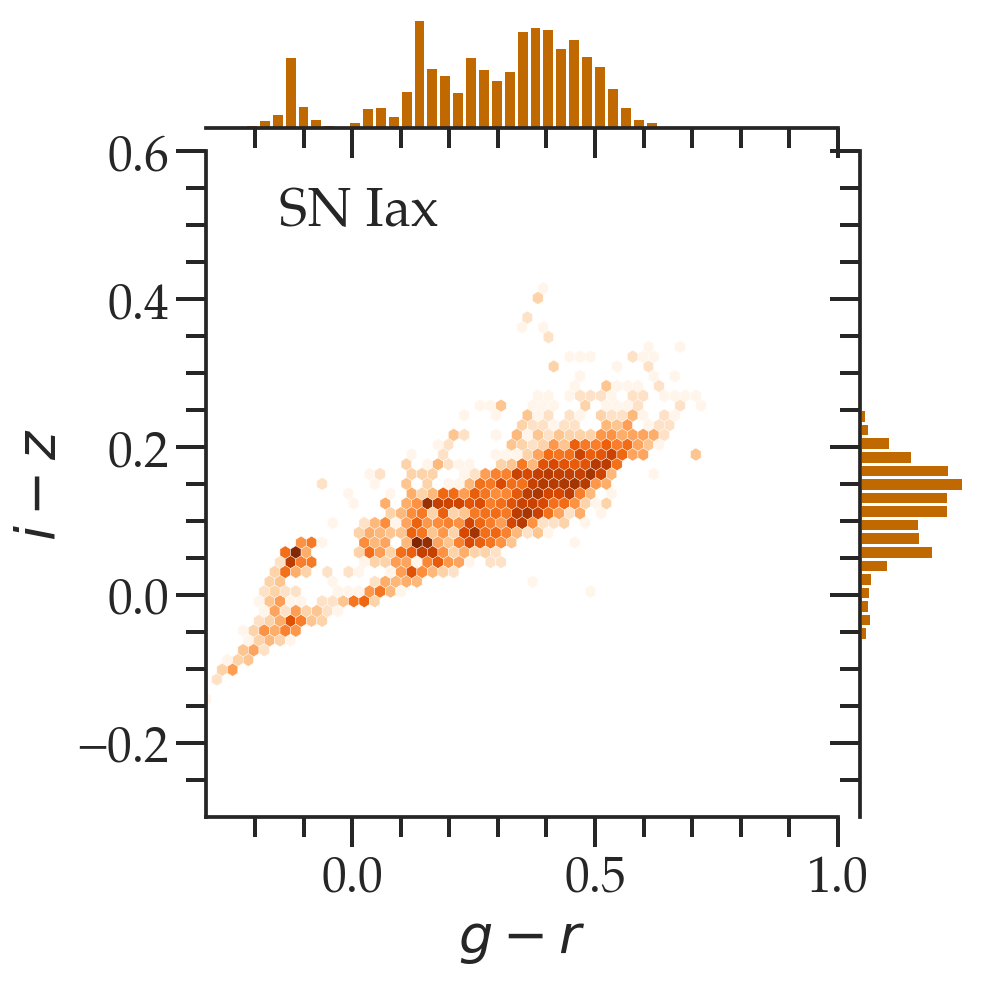

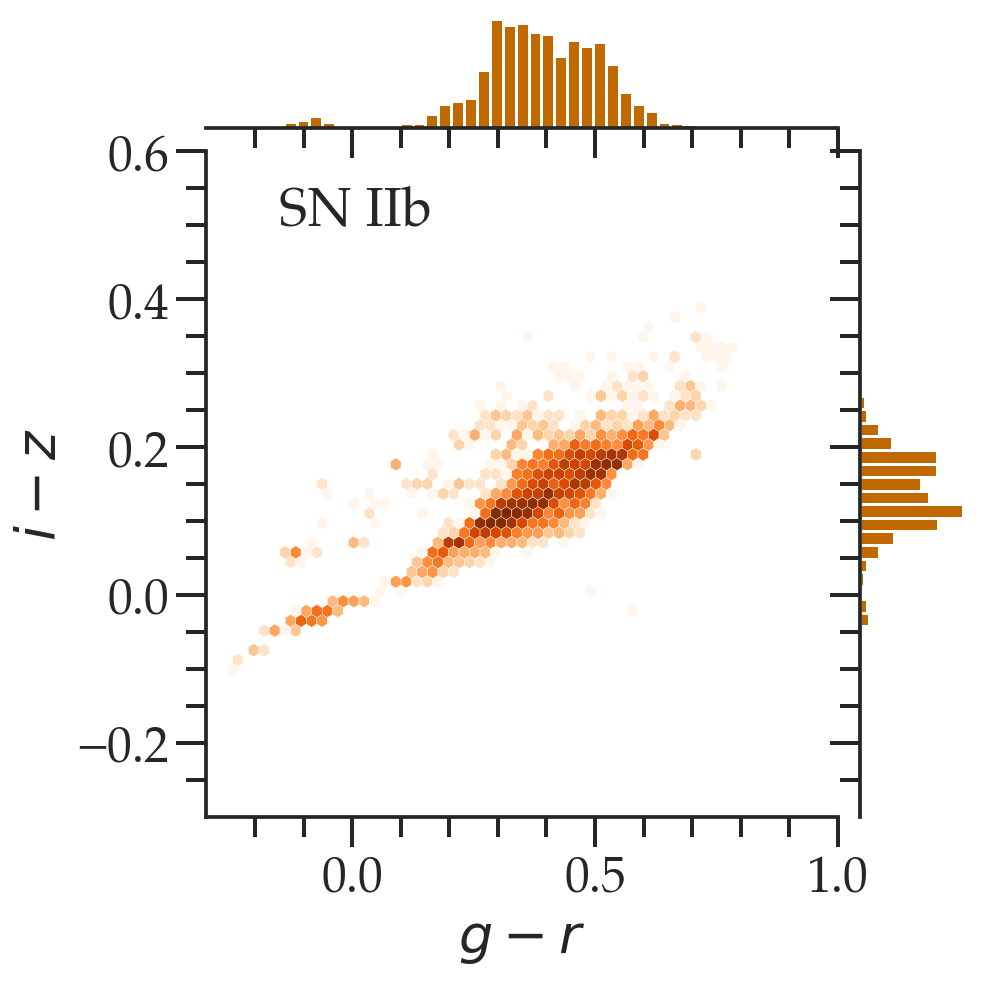

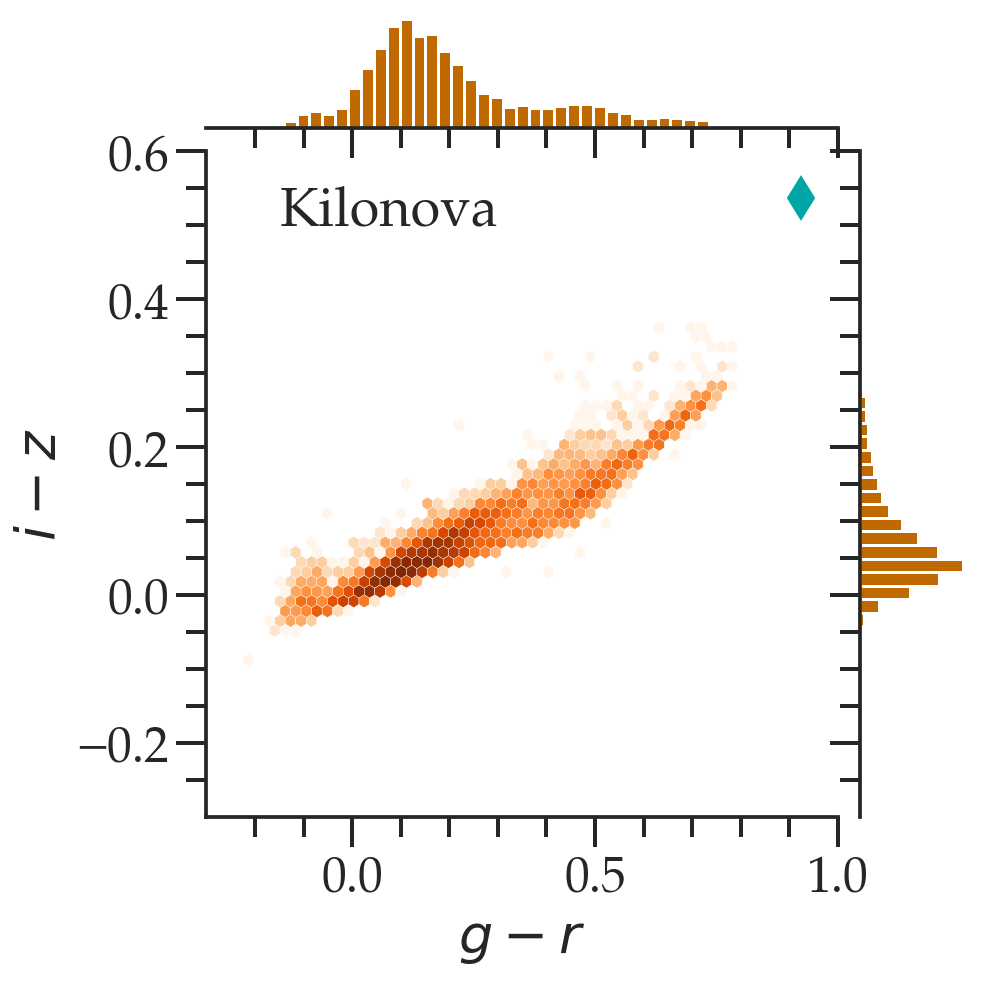

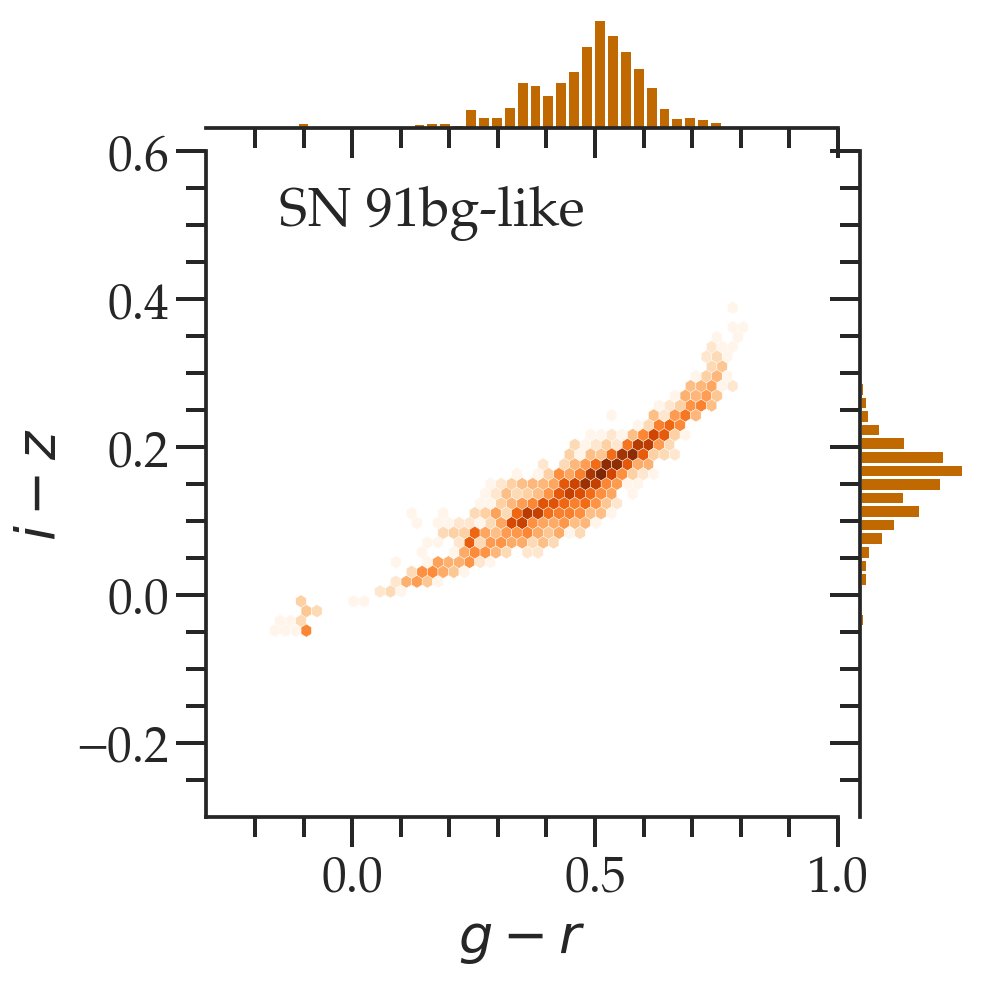

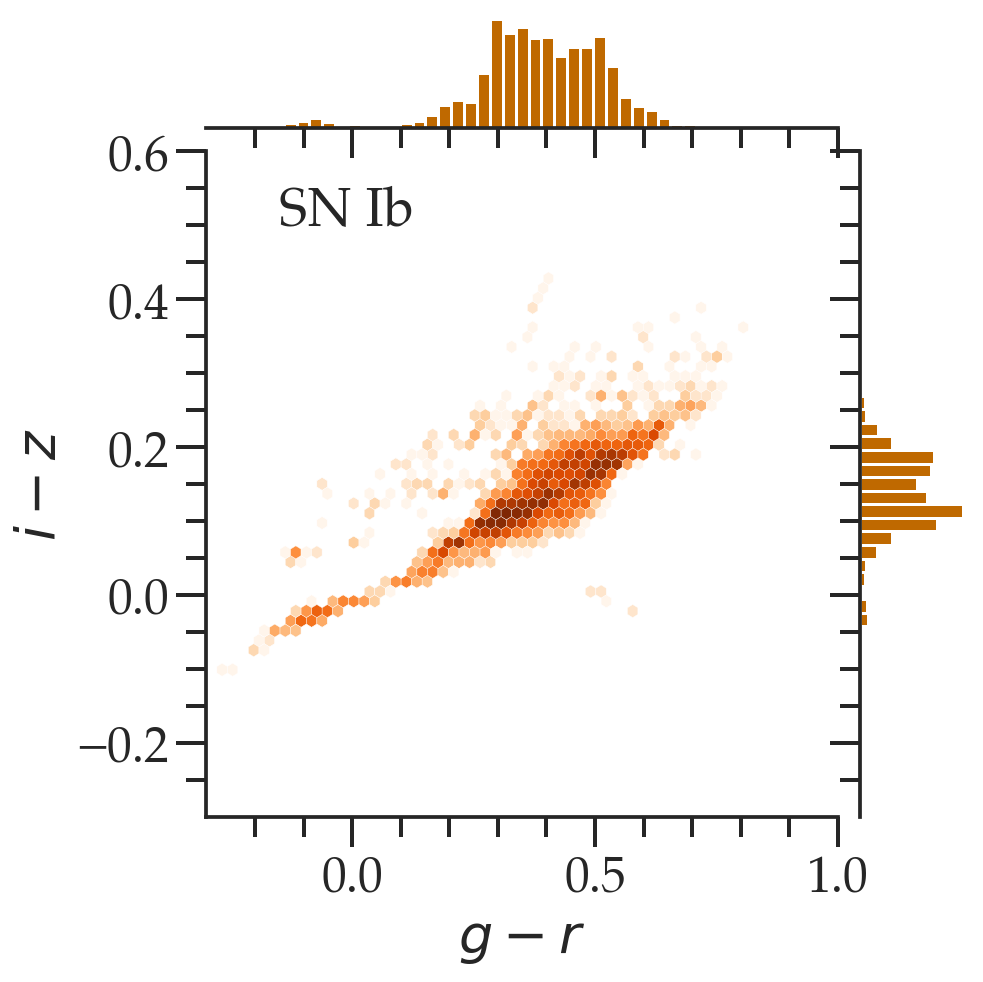

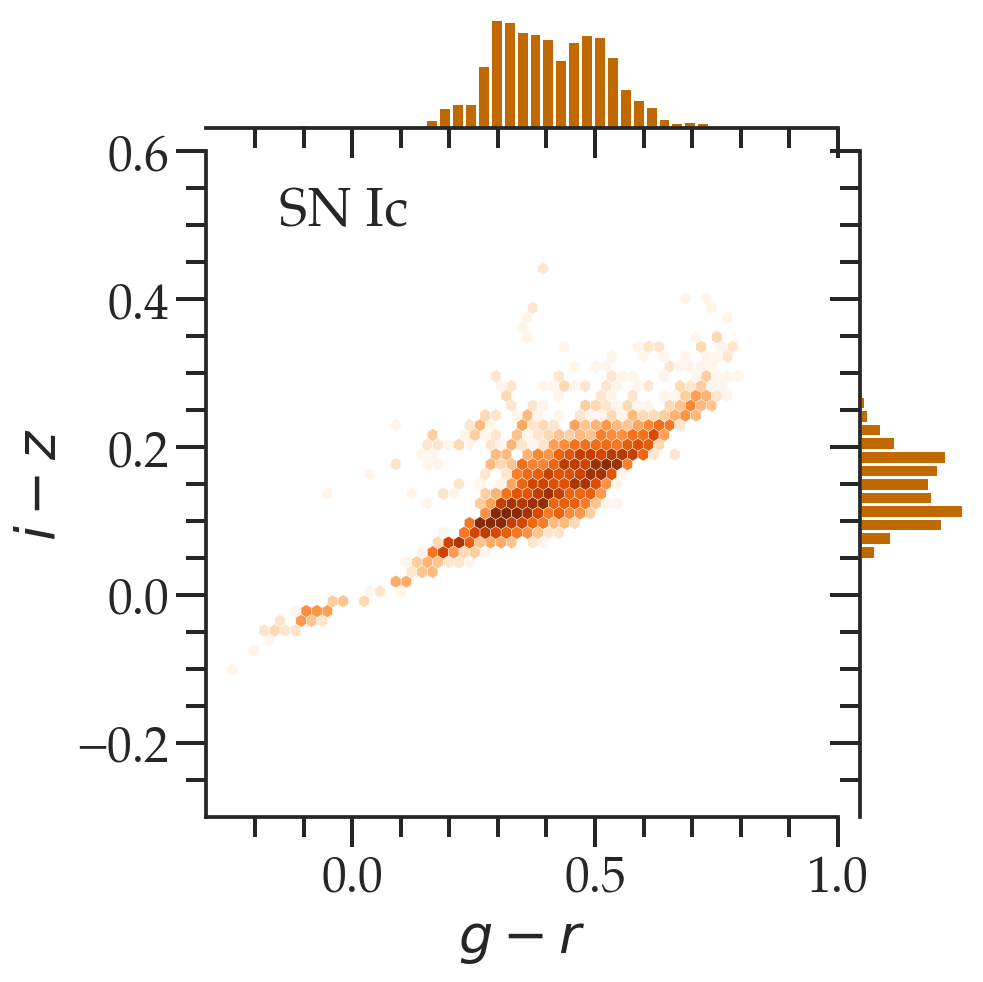

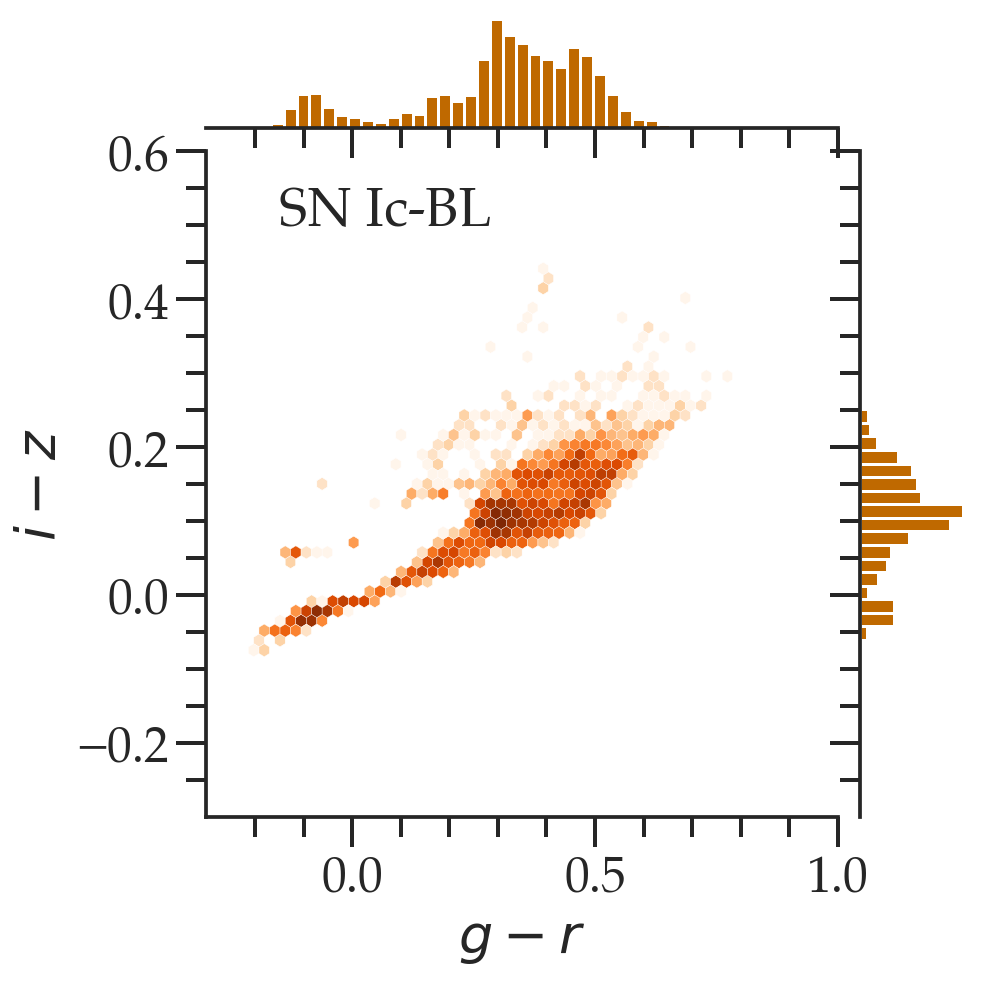

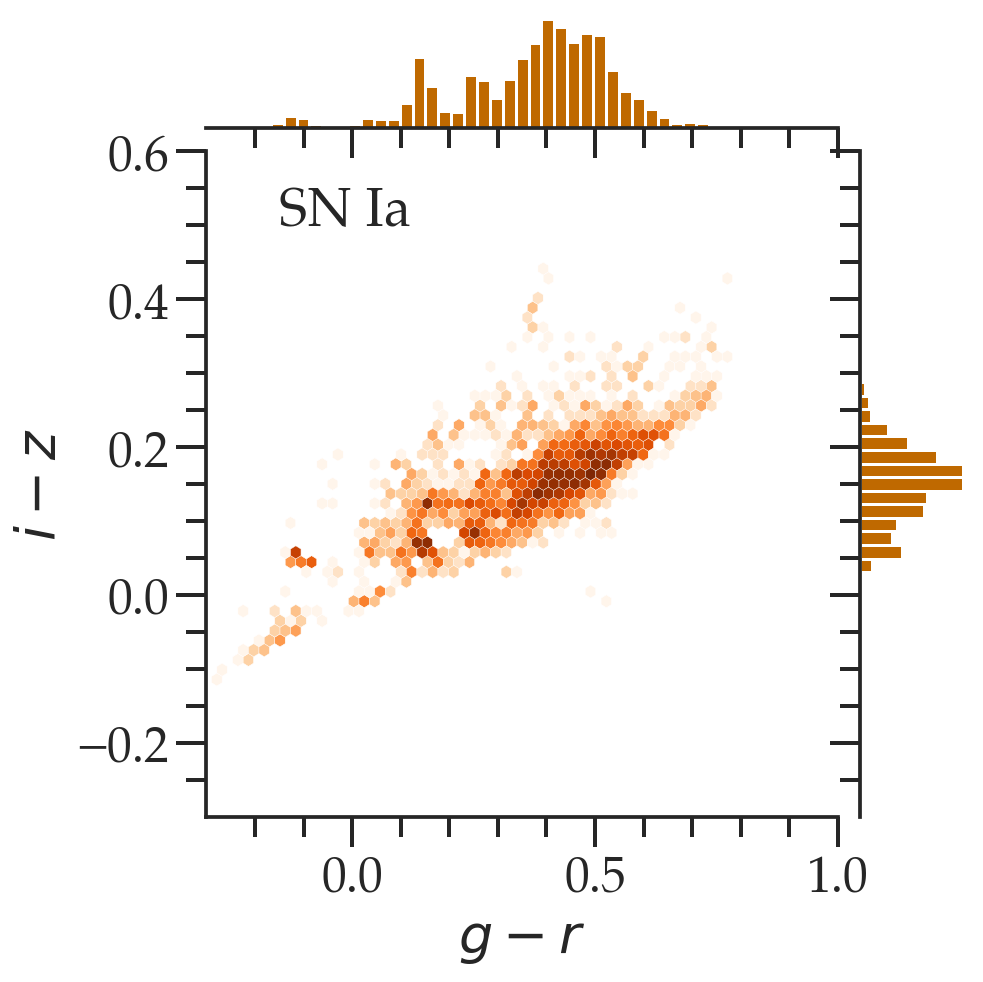

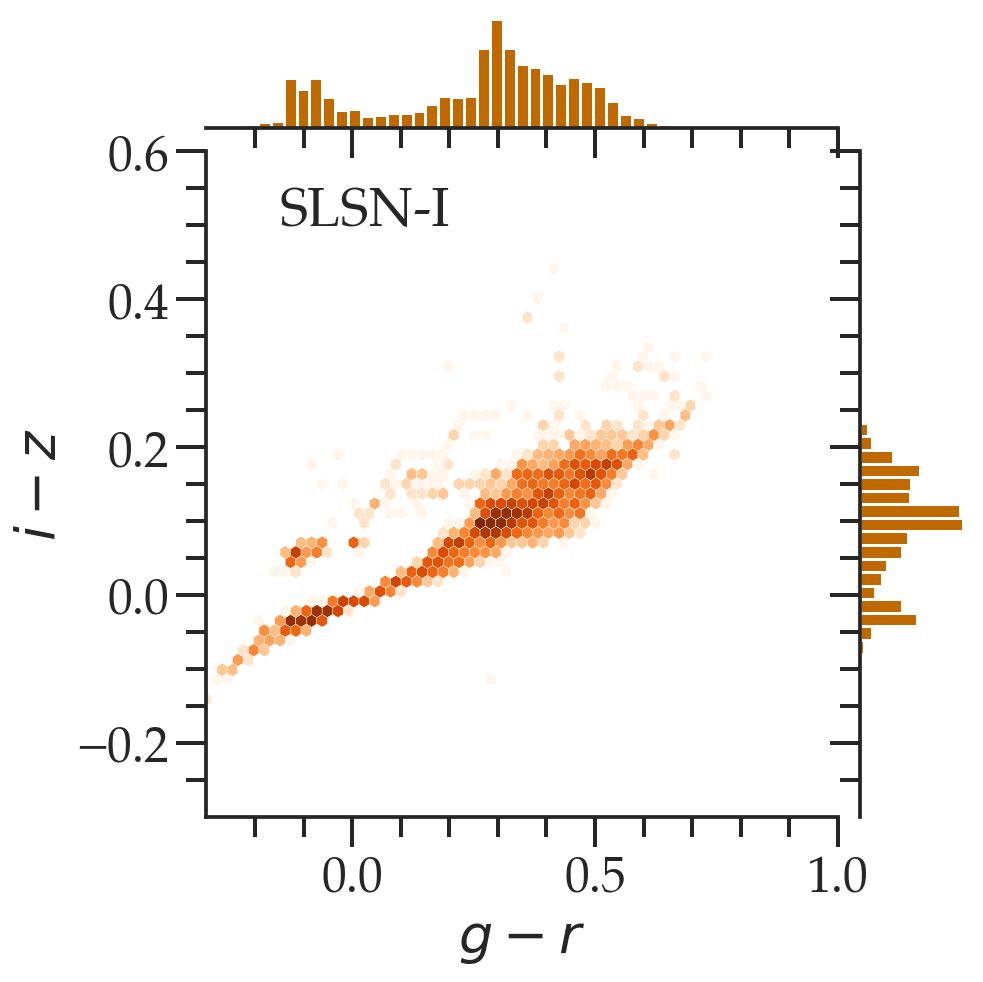

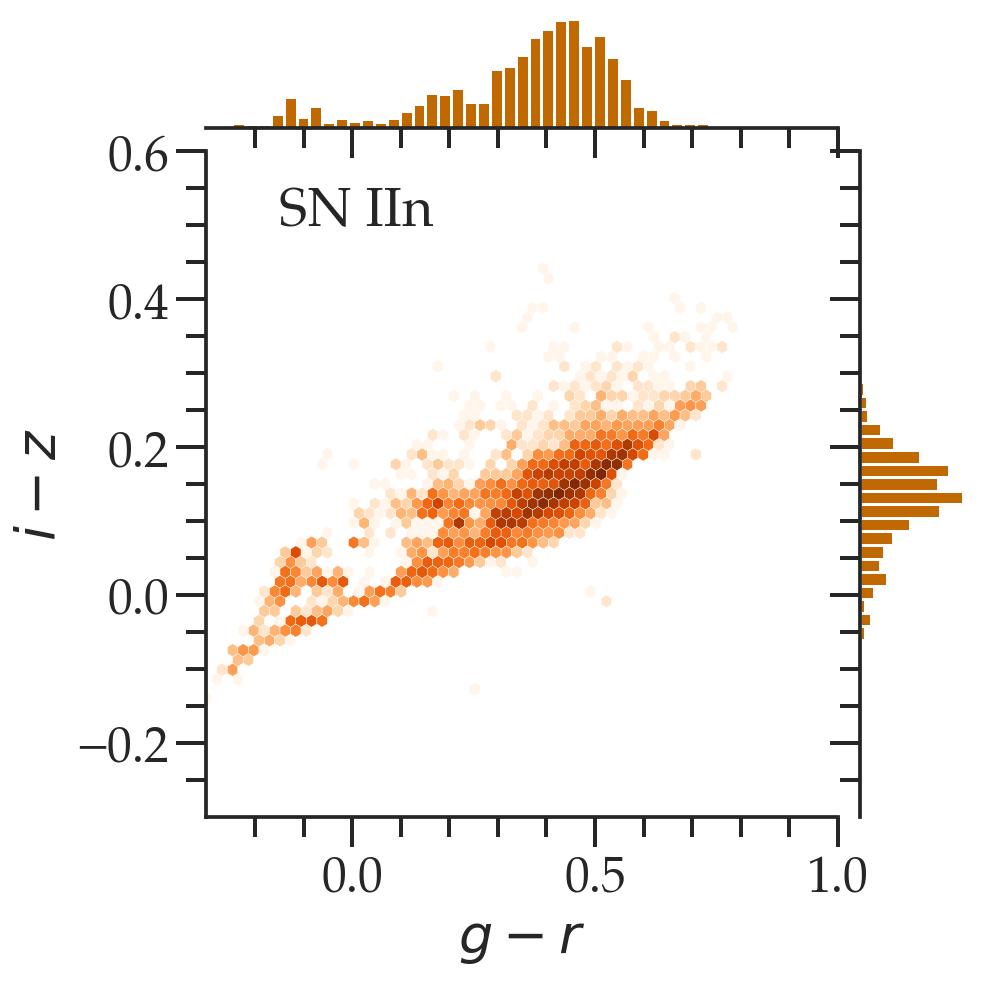

In [136]:
sns.set_context("talk",font_scale=1.5)

sns.set_style('white', {'axes.linewidth': 0.5})
plt.rcParams['xtick.major.size'] = 15
plt.rcParams['ytick.major.size'] = 15

plt.rcParams['xtick.minor.size'] = 10
plt.rcParams['ytick.minor.size'] = 10
plt.rcParams['xtick.minor.width'] = 2
plt.rcParams['ytick.minor.width'] = 2

plt.rcParams['xtick.major.width'] = 2
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True
plt.rcParams['xtick.top'] = False #just for these plots
plt.rcParams['ytick.right'] = False #just for these plots

plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
## for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

plt.rcParams['xtick.top'] = False #just for these plots
plt.rcParams['ytick.right'] = False #just for these plots
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'

#classes_plot = [classes[3], classes[6]]
#names_plot = ['SN Iax', 'SN 91bg-like']
classes_plot = classes
names_plot = names 

bands = ['g', 'r', 'i', 'z']

cols = sns.color_palette("colorblind", 12)
N4993_g = 15.0769
N4993_r = 14.153
N4993_i = 13.9573
N4993_z = 13.42
N4993_y = 13.2019

for i in np.arange(len(classes_plot)):
    g_min_r = classes_plot[i]["Mag_true_g_lsst_z0"].values - classes_plot[i]["Mag_true_r_lsst_z0"].values
    r_min_i = classes_plot[i]["Mag_true_r_lsst_z0"].values - classes_plot[i]["Mag_true_i_lsst_z0"].values
    i_min_z = classes_plot[i]["Mag_true_i_lsst_z0"].values - classes_plot[i]["Mag_true_z_lsst_z0"].values

    g = sns.JointGrid(x=g_min_r, y=i_min_z,  xlim=(-0.3, 1.), ylim=(-0.3, 0.6), height=7)
    g = g.plot_joint(plt.hexbin, color="#4CB391",cmap='Oranges', edgecolor="w",linewidth=0.2, gridsize=60, extent=[-0.3, 1., -0.3, 0.6], bins='log')
    _ = g.ax_marg_x.hist(g_min_r,
                          bins=np.linspace(-0.3, 1., 50), density=True, fill=True, color='#BF6900')
    _ = g.ax_marg_y.hist(i_min_z, 
                          orientation="horizontal",
                          bins=np.linspace(-0.3,0.6, 50), density=True, fill=True, color='#BF6900')

    if names[i] == 'Kilonova':
        g.ax_joint.plot(N4993_g - N4993_r, N4993_i - N4993_z, 'd', c='#00A6A6', ms=15)
    plt.xlabel(r"$g-r$")
    plt.text(-0.15, 0.5, "%s"%names_plot[i])
    plt.ylabel(r"$i-z$")
    plt.savefig("../plots/GP_ELAsTiCCValidation_SmallSet_HexGrid_%s_gr_iz.png"%names_plot[i].replace(" ", ""),bbox_inches='tight',dpi=200)

Text(14.875, 0.5, '$i-z$')

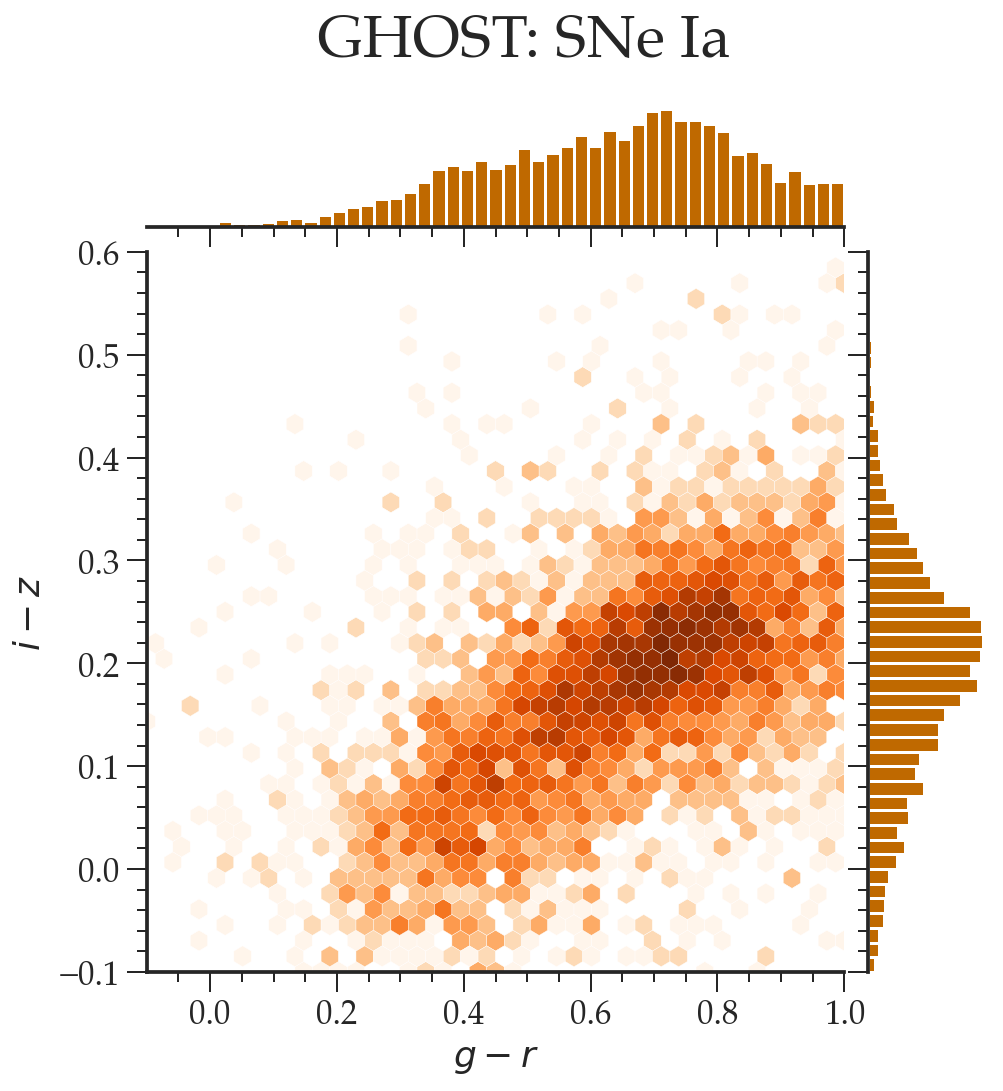

In [77]:
plt.rcParams['xtick.top'] = False #just for these plots
plt.rcParams['ytick.right'] = False #just for these plots

bands = ['g', 'r', 'i', 'z']

cols = sns.color_palette("colorblind", 10)

g_min_r = GHOST.loc[GHOST['TransientClass'] == 'SN Ia', 'gKronMag'].values-GHOST.loc[GHOST['TransientClass'] == 'SN Ia', 'rKronMag'].values
r_min_i =  GHOST.loc[GHOST['TransientClass'] == 'SN Ia', 'rKronMag'].values-GHOST.loc[GHOST['TransientClass'] == 'SN Ia', 'iKronMag'].values
i_min_z =  GHOST.loc[GHOST['TransientClass'] == 'SN Ia', 'iKronMag'].values-GHOST.loc[GHOST['TransientClass'] == 'SN Ia', 'zKronMag'].values

g = sns.JointGrid(x=g_min_r, y=i_min_z,  xlim=(-0.1, 1.), ylim=(-0.1, 0.6), height=7)
g = g.plot_joint(plt.hexbin, color="#4CB391",cmap='Oranges', edgecolor="w",linewidth=0.2, gridsize=40, extent=[-0.1, 1., -0.1, 0.6], bins='log')
_ = g.ax_marg_x.hist(g_min_r,
                      bins=np.linspace(-0.1, 1, 50), density=True, fill=True, color='#BF6900')
_ = g.ax_marg_y.hist(i_min_z, 
                      orientation="horizontal",
                      bins=np.linspace(-0.1, 0.6, 50), density=True, fill=True, color='#BF6900')
g.fig.suptitle("GHOST: SNe Ia", fontsize=30, y=1.05)
plt.xlabel(r"$g-r$")
plt.ylabel(r"$i-z$")

In [89]:
classes_plot[0].columns.values

array(['snid', 'z', 'host_specz', 'host_photoz', 'type', 'pkmjd', 'libid',
       'pkmag_u', 'pkmag_g', 'pkmag_r', 'pkmag_i', 'pkmag_z', 'pkmag_Y',
       'SIM_MODEL_NAME', 'SIM_MODEL_INDEX', 'SIM_TYPE_INDEX',
       'SIM_TYPE_NAME', 'SIM_TEMPLATE_INDEX', 'SIM_LIBID',
       'SIM_NGEN_LIBID', 'SIM_NOBS_UNDEFINED', 'SIM_SEARCHEFF_MASK',
       'SIM_REDSHIFT_HELIO', 'SIM_REDSHIFT_CMB', 'SIM_REDSHIFT_HOST',
       'SIM_REDSHIFT_FLAG', 'SIM_VPEC', 'SIM_HOSTLIB_GALID',
       'SIM_HOSTLIB(LOG_SFR)', 'SIM_HOSTLIB(LOGMASS_TRUE)', 'SIM_DLMU',
       'SIM_LENSDMU', 'SIM_RA', 'SIM_DEC', 'SIM_MWEBV', 'SIM_PEAKMJD',
       'SIM_MAGSMEAR_COH', 'SIM_AV', 'SIM_RV', 'SIM_PEAKMAG_u',
       'SIM_PEAKMAG_g', 'SIM_PEAKMAG_r', 'SIM_PEAKMAG_i', 'SIM_PEAKMAG_z',
       'SIM_PEAKMAG_Y', 'SIM_TEMPLATEMAG_u', 'SIM_TEMPLATEMAG_g',
       'SIM_TEMPLATEMAG_r', 'SIM_TEMPLATEMAG_i', 'SIM_TEMPLATEMAG_z',
       'SIM_TEMPLATEMAG_Y', 'SIM_EXPOSURE_u', 'SIM_EXPOSURE_g',
       'SIM_EXPOSURE_r', 'SIM_EXPOSURE_i', 'SIM_E

/var/folders/5v/w17zxffn07nf1f90q2rfbdym0001vx/T/ipykernel_47843/4283931562.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cols = np.array([sns.color_palette("colorblind", 10)[4], cols[4], cols[3], cols[0], 'tab:red', cols[7]]) #u and y probably need changing
/var/folders/5v/w17zxffn07nf1f90q2rfbdym0001vx/T/ipykernel_47843/4283931562.py:91: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels([''])
/var/folders/5v/w17zxffn07nf1f90q2rfbdym0001vx/T/ipykernel_47843/4283931562.py:91: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels([''])
/var/folders/5v/w17zxffn07nf1f90q2rfbdym0001vx/T/ipykernel_47843/4283931562.py:91: UserWarning: FixedFormatter should only be used together 

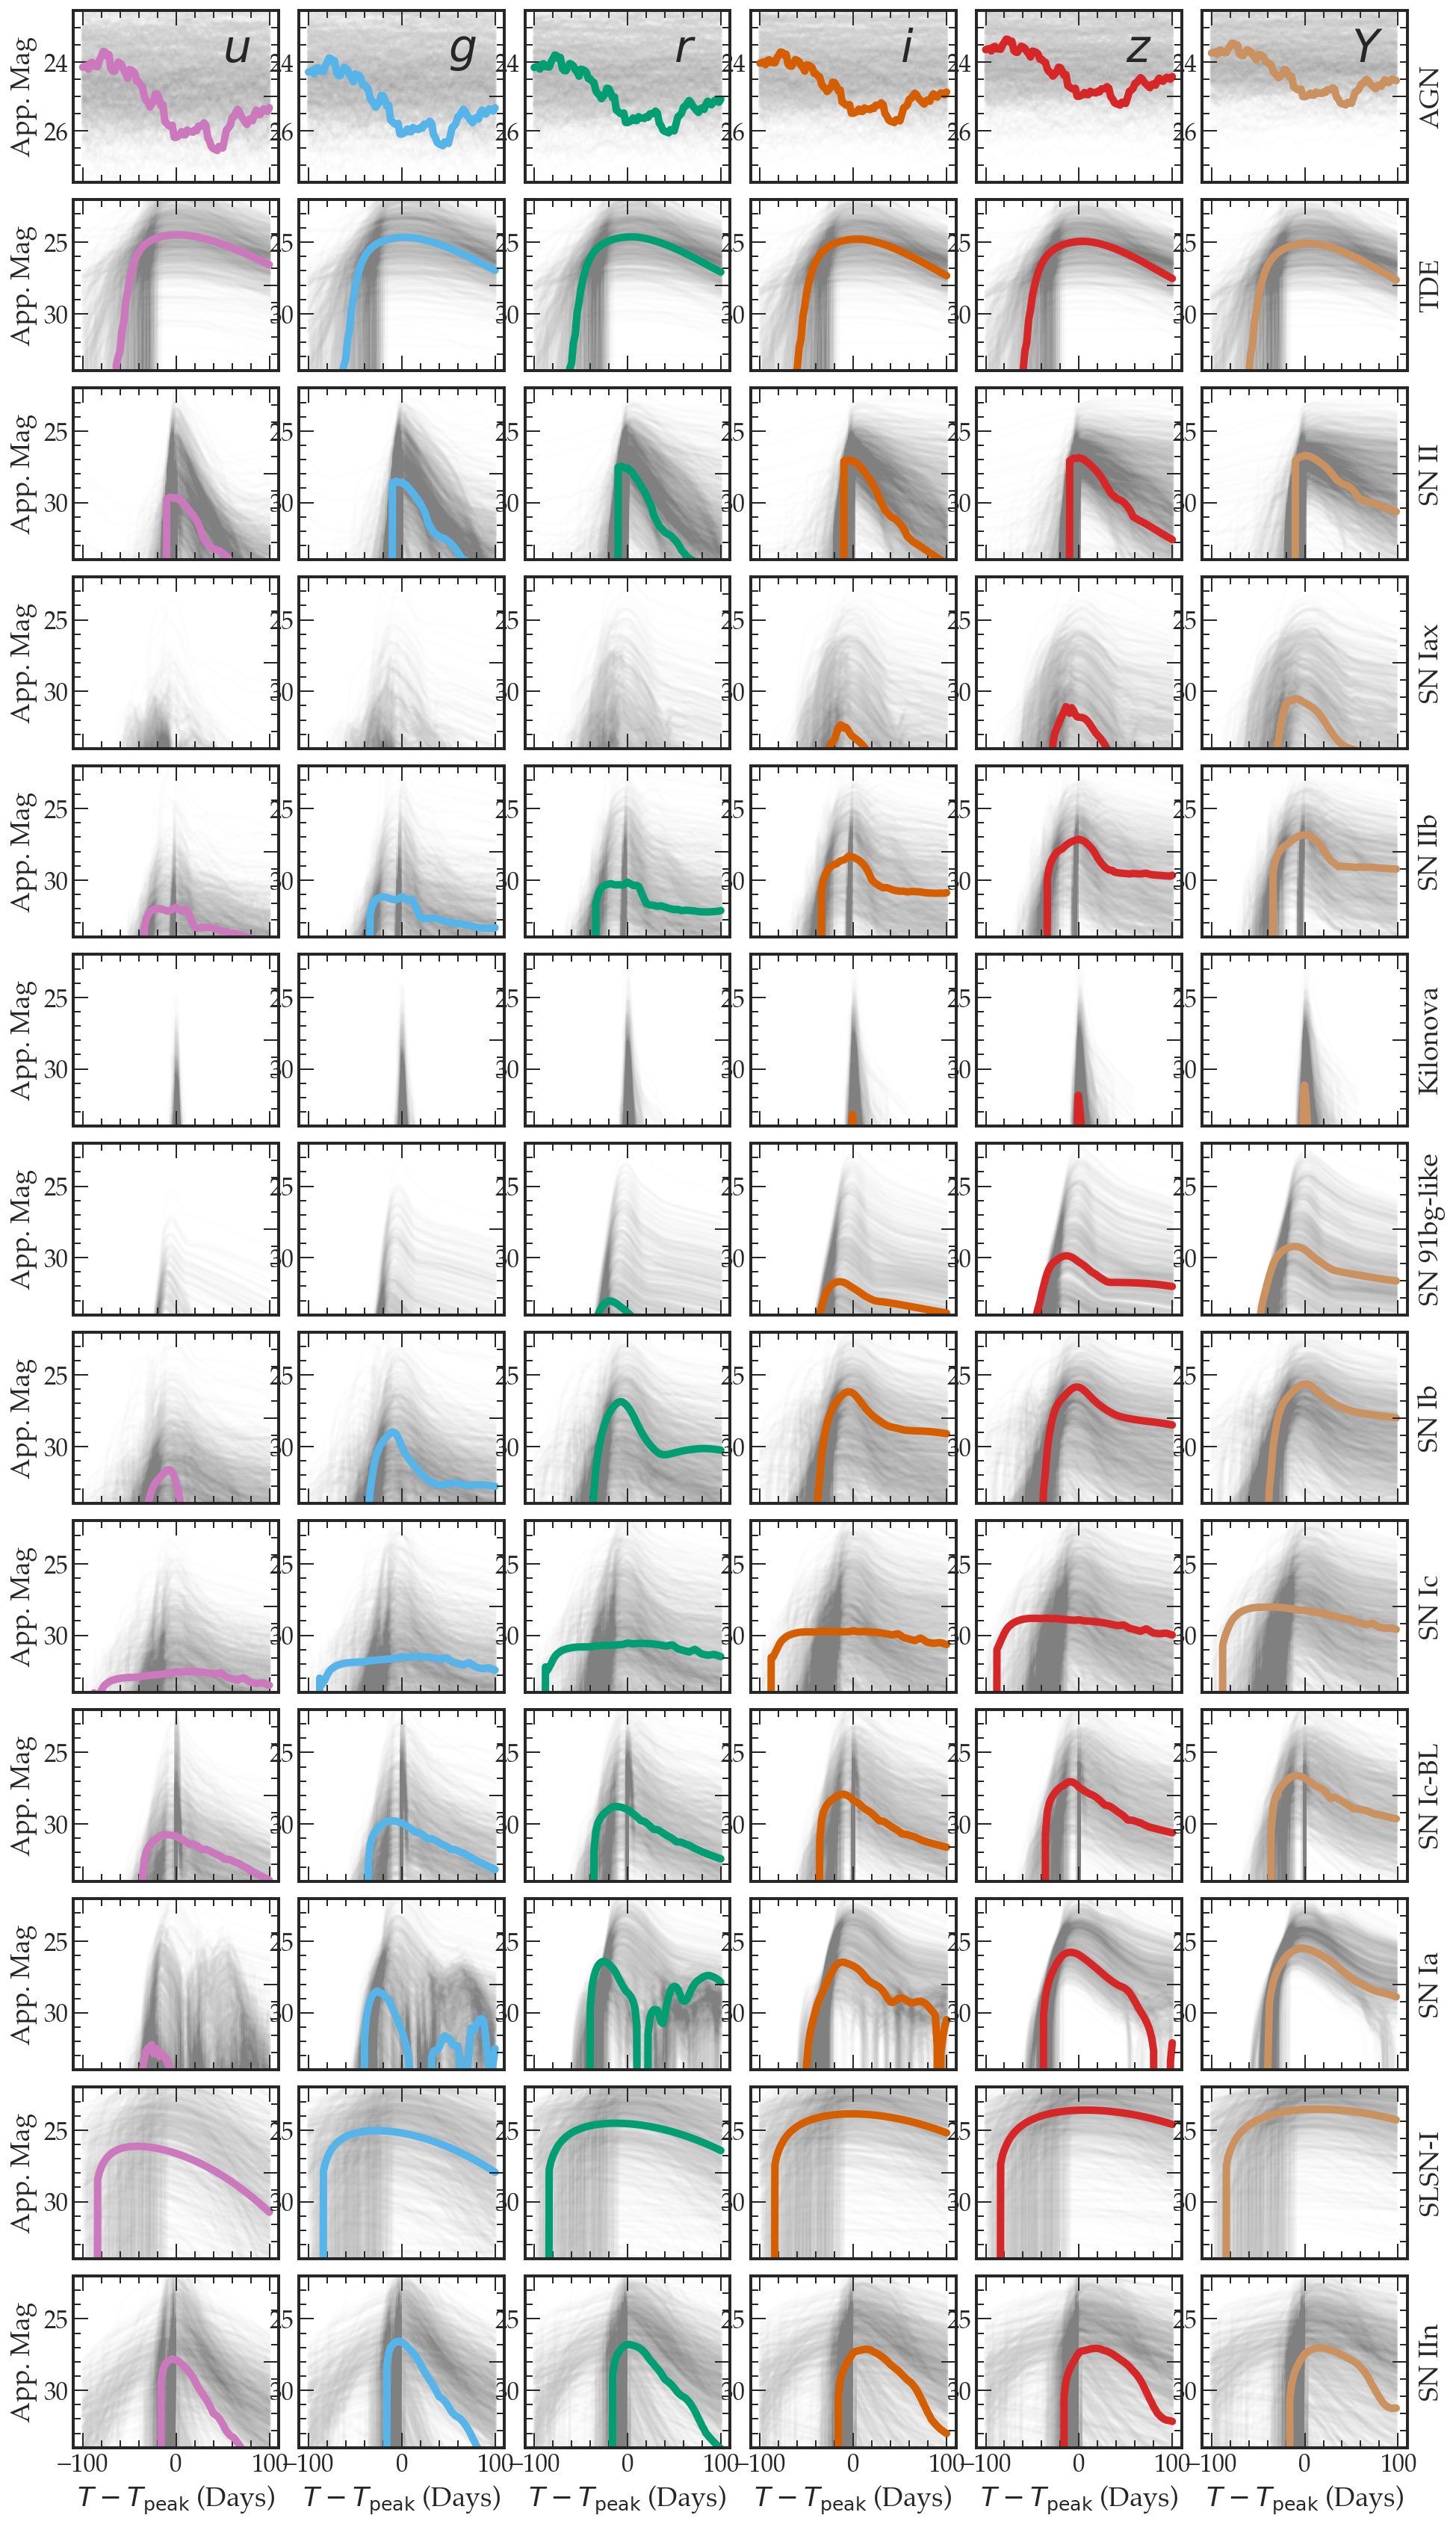

In [134]:
sns.set_context("talk",font_scale=1.)

sns.set_style('white', {'axes.linewidth': 0.5})
plt.rcParams['xtick.major.size'] = 10
plt.rcParams['ytick.major.size'] = 10

plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['ytick.minor.size'] = 5
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.minor.width'] = 1

plt.rcParams['xtick.major.width'] = 1
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['xtick.bottom'] = True
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.left'] = True
plt.rcParams['ytick.right'] = True

plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
## for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

bands = ['u', 'g', 'r', 'i', 'z', 'Y']

classes_plot = classes.copy() 
names_plot = names.copy() 

cols = sns.color_palette("colorblind", 10)
cols_hex = cols.as_hex()
cols = np.array([cols[3], cols[1], cols[8], cols[2], cols[9], cols[0], cols[4], cols[5], cols[7],cols[6]])
cols = np.array([sns.color_palette("colorblind", 10)[4], cols[4], cols[3], cols[0], 'tab:red', cols[7]]) #u and y probably need changing

fig, axs = plt.subplots(figsize=(16,30), nrows=len(classes_plot), ncols=6,sharex=True, sharey=False, gridspec_kw={'wspace':0.1, 'hspace':0.1})
TID_toPlot = []
for j in np.arange(len(classes_plot)):
    for k in np.arange(len(bands)):        
        mag_set = []
        classes_plot[j] = classes_plot[j][classes_plot[j].snid != 15709]
        for idx, row in classes_plot[j].iterrows():
            if idx%5==0:
                if j==5:
                    pk = row['pkmjd']
                else:
                    pk = 53200
                time = np.array(row['MJD_%s'%bands[k]]) - pk#.values #jd']
                mag = row['SIMMAGOBS_%s'%bands[k]]#.values 
                axs[j,k].plot(time, mag,  alpha=0.01, c='gray')#c=cols[k])
                
        if k == 0:
            medianMag = np.median(classes_plot[j]['pkmag_%s'%bands[k]])
            oneToPlot = classes_plot[j].iloc[np.nanargmin(np.abs(classes_plot[j]['pkmag_%s'%bands[k]] - medianMag))]
            TID_toPlot.append(oneToPlot['snid'])
        else:
            oneToPlot = classes_plot[j].loc[classes_plot[j].snid == TID_toPlot[j]]
                      
        if j ==5:
            pk = oneToPlot['pkmjd'] 
        else: 
            pk = 53200
        try:
            oneTime = np.array(oneToPlot['MJD_%s'%bands[k]]) - pk  #oneToPlot['pkmjd']#.values[0].values#- oneToPlot['pkmjd']
        except:
            try:
                oneTime = np.array(oneToPlot['MJD_%s'%bands[k]].values[0]) - pk
            except:
                 oneTime = np.array(oneToPlot['MJD_%s'%bands[k]].values[0]) - pk.values               
        oneMag =  oneToPlot['SIMMAGOBS_%s'%bands[k]]#.replace(np.nan, 99.0)#.values[0].values
        try:
            axs[j,k].plot(oneTime, oneMag, c=cols[k], lw=5)
        except:
            axs[j,k].plot(oneTime, oneMag.values[0], c=cols[k], lw=5)
        if j==0:
            axs[j,k].set_ylim((27.5, 22.5))
        else:
            axs[j,k].set_ylim((34, 22))   
        if k==0:
            axs[j,k].set_ylabel("App. Mag")        
        ax2 = axs[j,k].twinx()
        ax2.set_yticklabels([''])
        if k==5:
            ax2.set_ylabel(names_plot[j], rotation=90)
        if j==len(classes_plot)-1:
            axs[j,k].set_xlabel(r"$T-T_{\rm peak}$ (Days)")
        if j==0:
            axs[j,k].text(50, 24, r"$%s$"%bands[k], fontsize=30)
plt.savefig("../plots/Model_LCs_ugrizY_allClass.png",bbox_inches='tight',dpi=200)

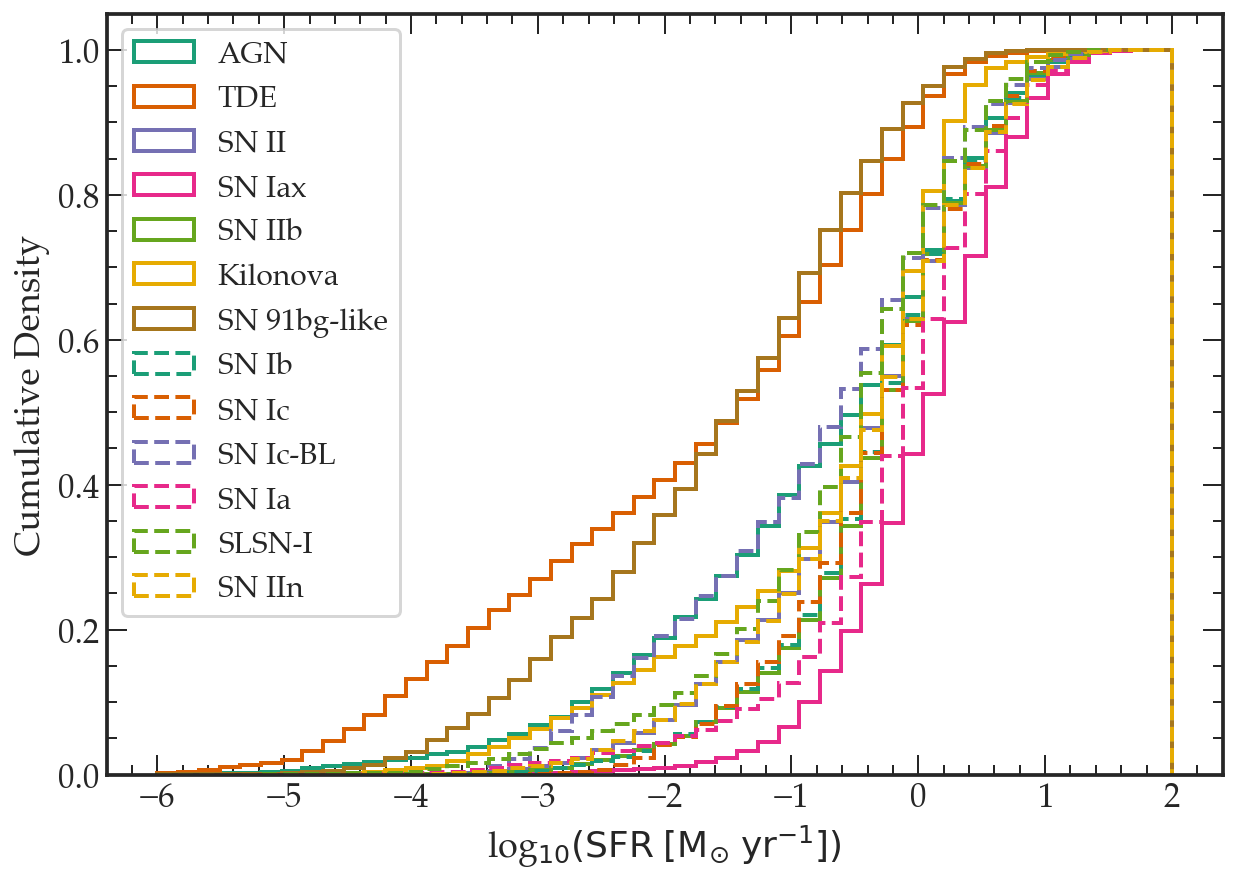

In [131]:
## for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

cols = sns.color_palette("Dark2", 14)


plt.figure(figsize=(10,7))
for i in np.arange(len(classes)):
    tclass = classes[i]
    if i <7:
        ls = '-'
    else:
        ls='--'
    plt.hist(tclass['SIM_HOSTLIB(LOG_SFR)'], density=True, histtype='step', cumulative=True, bins=np.linspace(-6, 2, 50), ls=ls, color=cols[i%7], lw=2, label=names[i])
    plt.xlabel(r"log$_{10}(\rm{SFR}\; [M_{\odot}\; yr^{-1}])$")
    plt.ylabel("Cumulative Density")
plt.legend(loc='upper left',fontsize=15)
plt.savefig("../plots/SCOTCH_CDF_SFR.png",bbox_inches='tight', dpi=200)

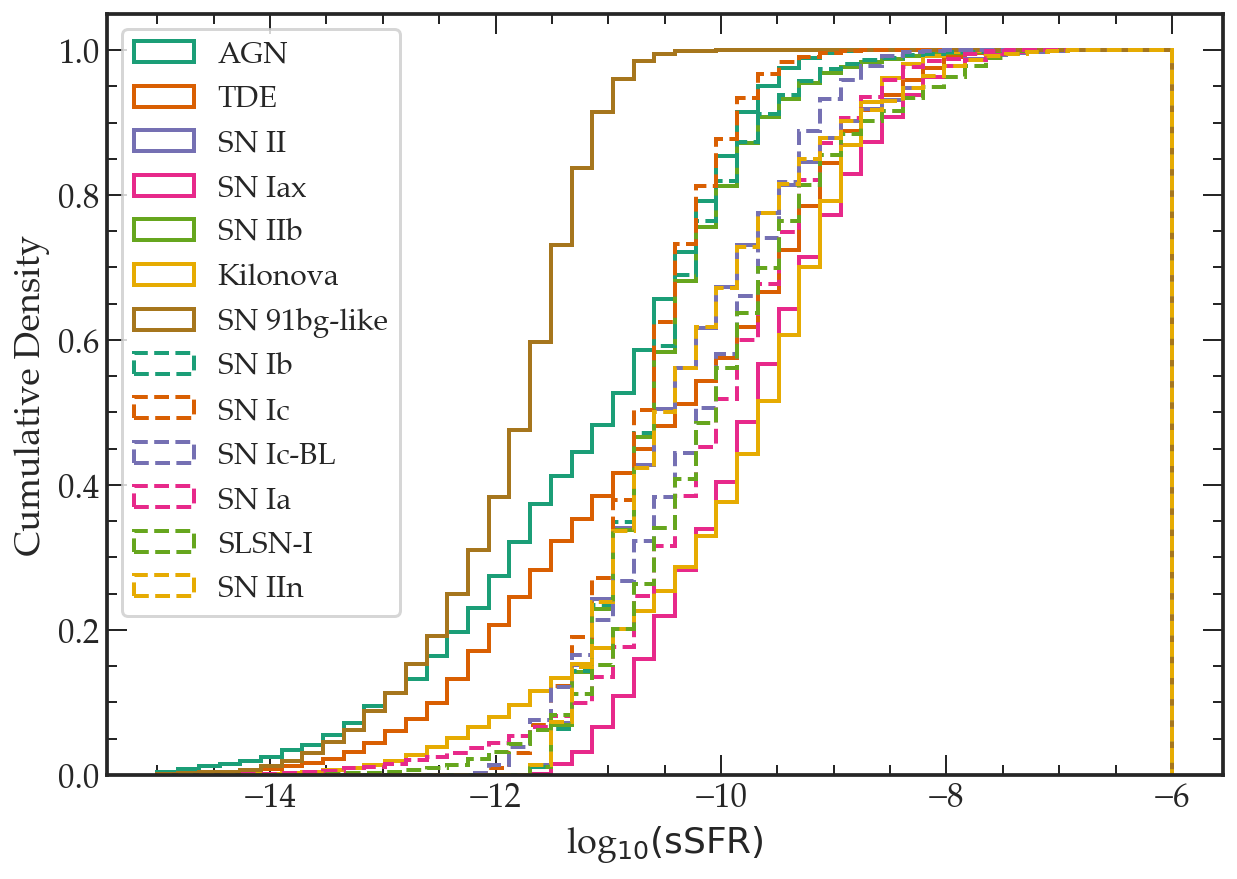

In [132]:
## for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

cols = sns.color_palette("Dark2", 14)


plt.figure(figsize=(10,7))
for i in np.arange(len(classes)):
    tclass = classes[i]
    if i <7:
        ls = '-'
    else:
        ls='--'
        
    sSFR = np.log10(10**tclass['SIM_HOSTLIB(LOG_SFR)']/10**tclass['SIM_HOSTLIB(LOGMASS_TRUE)'])
    plt.hist(sSFR, density=True, histtype='step', cumulative=True, bins=np.linspace(-15, -6, 50), ls=ls, color=cols[i%7], lw=2, label=names[i])
    plt.xlabel(r"log$_{10}(\rm{sSFR})$")
    plt.ylabel("Cumulative Density")
plt.legend(loc='upper left',fontsize=15)
plt.savefig("../plots/SCOTCH_CDF_sSFR.png",bbox_inches='tight', dpi=200)

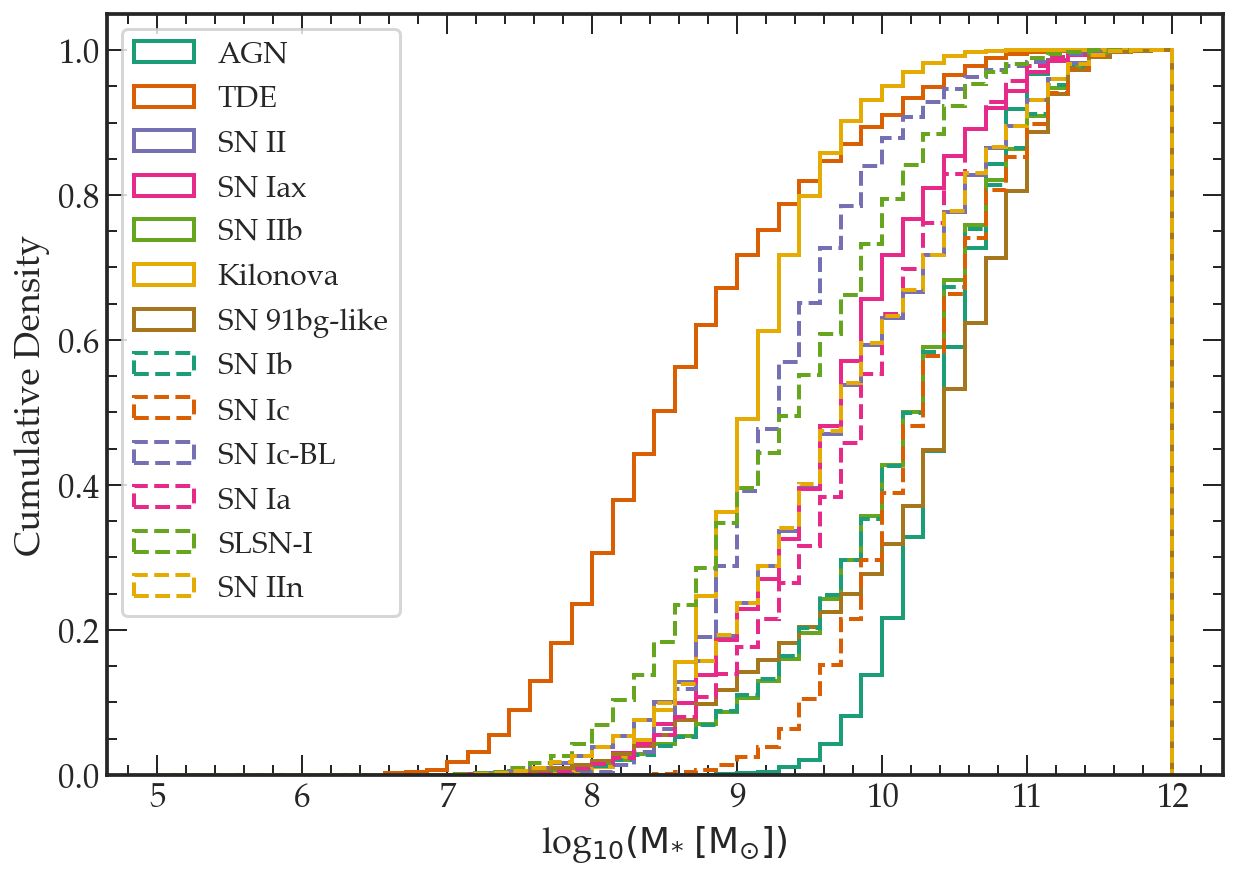

In [133]:
lines = ["-","--","-.",":"]
## for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

cols = sns.color_palette("Dark2", 14)

plt.figure(figsize=(10,7))
for i in np.arange(len(classes)):
    tclass = classes[i]
    if i <7:
        ls = '-'
    else:
        ls='--'
    plt.hist(tclass['SIM_HOSTLIB(LOGMASS_TRUE)'], density=True, histtype='step', cumulative=True,ls=ls, bins=np.linspace(5, 12, 50), color=cols[i%7], lw=2, label=names[i])
    plt.xlabel(r"log$_{10}(\rm{M_{*}}\; [M_{\odot}])$")
    plt.ylabel("Cumulative Density")
plt.legend(loc='upper left',fontsize=15)
plt.savefig("../plots/SCOTCH_CDF_Msol.png",bbox_inches='tight', dpi=200)